In [1]:
# standard library
import os
import sys
import time
import random
from itertools import cycle

# scientific / data
import numpy as np
import torch
import trimesh
import networkx as nx

# plotting / widgets
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import k3d

# progress bars
from tqdm.notebook import tqdm  # or `from tqdm import tqdm` if you prefer the console version

# SciPy / sklearn
from scipy.spatial import cKDTree, ConvexHull, Delaunay
from sklearn.decomposition import PCA

# your neural-CBF system
from neural_clbf.systems import ControlAffineSystem
from neural_clbf.controllers.cbf_controller import CBFController
from neural_clbf.controllers.controller_utils import normalize_with_angles
from neural_clbf.datamodules.episodic_datamodule import EpisodicDataModule
from neural_clbf.experiments import ExperimentSuite

from configs.get_config import get_config_from_yml
from GINN.shape_boundary_helper import ShapeBoundaryHelper
from GINN.helpers.mp_manager import MPManager
from GINN.helpers.timer_helper import TimerHelper
from GINN.morse.scc_surfacenet_manager import SCCSurfaceNetManager
from GINN.problem_sampler import ProblemSampler
from GINN.visualize.plotter_3d import Plotter3d

from train.train_utils.autoclip import AutoClip
from train.train_utils.latent_sampler import sample_new_z

from utils import get_model, get_stateless_net_with_partials, set_all_seeds, get_is_out_mask
from notebooks.notebook_utils import get_mesh_for_latent

from models.model_utils import tensor_product_xz
from cbf import CBFModel
from simple_cbf import SimpleCBFModel

from torch.func import functional_call, jacrev, jacfwd, vmap

/sfs/weka/scratch/rhm4nj/cral/cral-ginn/ginn/neural_clbf/neural_clbf/systems/f16.py:22: UserWarning: Could not import F16 module; is AeroBench installed?
  warn("Could not import F16 module; is AeroBench installed?")
/home/rhm4nj/.local/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/sfs/weka/scratch/rhm4nj/cral/cral-ginn/ginn/neural_clbf/neural_clbf/experiments/__init__.py:44: UserWarning: Could not import HW module; is ROS installed?
  warn("Could not import HW module; is ROS installed?")


In [2]:
data_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/myvis/data_gen/replica/room_0_objects"
env_name = "_".join(data_directory.split("/")[-1].split("_")[:2])
points_name = "original.npy"
points = {}

print(env_name)

for dirname in sorted(os.listdir(data_directory)):
    points_path = os.path.join(data_directory, dirname, points_name)
    points[dirname] = np.load(points_path)

room_0


In [3]:
class PointsManager:
    def __init__(self, points_dict):
        """
        Args:
            points_dict: dict[str, np.ndarray], each array is (N_i, 3)
        """
        self.original_points = {k: v.copy() for k, v in points_dict.items()}
        self.translations = {k: np.zeros(3) for k in points_dict}
        self._combined_tree = None
        self._combined_tree_needs_update = True

    def _get_translated_points(self, name):
        return self.original_points[name] + self.translations[name]

    def _rebuild_combined_tree(self):
        all_points = np.vstack([
            self._get_translated_points(name) for name in self.original_points
        ])
        self._combined_tree = cKDTree(all_points)
        self._combined_tree_needs_update = False

    def move(self, name, translation):
        """Move a point cloud by translation (x, y, z)."""
        if name not in self.translations:
            raise KeyError(f"No point cloud named '{name}'")
        self.translations[name] += np.asarray(translation)
        self._combined_tree_needs_update = True

    def get_all_points(self):
        """Return all translated points from all clouds as a single (N, 3) array."""
        return np.vstack([self.get_points(name) for name in self.original_points])

    def get_points(self, name):
        """Get the current (translated) points for a named point cloud."""
        if name not in self.original_points:
            raise KeyError(f"No point cloud named '{name}'")
        return self._get_translated_points(name)

    def reset(self):
        """Reset all point clouds to their original position."""
        for name in self.translations:
            self.translations[name] = np.zeros(3)
        self._combined_tree_needs_update = True

    def get_closest_distance(self, point):
        """
        Returns the distance to the closest point across all clouds using the fastest method.
        """
        point = np.asarray(point).reshape(1, 3)

        if self._combined_tree is None or self._combined_tree_needs_update:
            self._rebuild_combined_tree()

        dist, _ = self._combined_tree.query(point)
        return dist[0]

    def plot(self, plot=None, point_size=0.02, display=False):
        """Plot all point clouds with k3d, using different colors."""
        if not plot:
            plot = k3d.plot()
        color_cycle = cycle([
            0xff0000, 0x00ff00, 0x0000ff, 0xffff00, 0xff00ff,
            0x00ffff, 0x888888, 0xff8800, 0x8800ff, 0x00ff88
        ])
        for name, pts in self.original_points.items():
            translated_pts = self.get_points(name)
            color = next(color_cycle)
            plot += k3d.points(translated_pts.astype(np.float32), color=color, point_size=point_size, name=name)
        if display:
            plot.display()
        return plot

class InteractivePlane:
    def __init__(self, point_on_plane, normal, plot, point_size=0.01, size=5, color=0x00FF00):
        self.size = size
        self.color = color
        self.plot = plot

        self.z_slider = widgets.FloatSlider(value=point_on_plane[2], min=-10, max=10, step=0.1, description="Z Height")
        self.nx_slider = widgets.FloatSlider(value=normal[0], min=-1, max=1, step=0.1, description="Normal X")
        self.ny_slider = widgets.FloatSlider(value=normal[1], min=-1, max=1, step=0.1, description="Normal Y")
        self.nz_slider = widgets.FloatSlider(value=normal[2], min=-1, max=1, step=0.1, description="Normal Z")

        self.z_slider.observe(self.update_plane, names="value")
        self.nx_slider.observe(self.update_plane, names="value")
        self.ny_slider.observe(self.update_plane, names="value")
        self.nz_slider.observe(self.update_plane, names="value")

        self.point_on_plane = np.array([point_on_plane[0], point_on_plane[1], self.z_slider.value])
        self.normal = np.array([self.nx_slider.value, self.ny_slider.value, self.nz_slider.value])
        self.mesh = self.create_plane()

        self.plot += self.mesh
        display(self.z_slider)

    def create_plane(self):
        normal = self.normal / np.linalg.norm(self.normal)
        v1 = np.cross(normal, np.array([1, 0, 0]))
        if np.linalg.norm(v1) < 1e-6:
            v1 = np.cross(normal, np.array([0, 1, 0]))
        v1 = v1 / np.linalg.norm(v1) * self.size
        v2 = np.cross(normal, v1)
        v2 = v2 / np.linalg.norm(v2) * self.size

        p1 = self.point_on_plane - v1 - v2
        p2 = self.point_on_plane + v1 - v2
        p3 = self.point_on_plane + v1 + v2
        p4 = self.point_on_plane - v1 + v2

        self.vertices = np.array([p1, p2, p3, p4], dtype=np.float32)
        faces = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.uint32)

        return k3d.mesh(self.vertices, faces, color=self.color, wireframe=False, name="interactive plane")

    def update_plane(self, _):
        self.point_on_plane[2] = self.z_slider.value
        self.normal = np.array([self.nx_slider.value, self.ny_slider.value, self.nz_slider.value])
        self.normal = self.normal / np.linalg.norm(self.normal)
        self.vertices[:, 2] = self.point_on_plane[2]
        self.mesh.vertices = self.vertices
        print(self.normal, self.point_on_plane)

class InteractivePoint:
    def __init__(self, point, plot, point_size=0.1, color=0xFF0000):
        self.plot = plot
        self.color = color
        self.point_size = point_size

        self.x_slider = widgets.FloatSlider(value=point[0], min=-50, max=50, step=0.01, description="X")
        self.y_slider = widgets.FloatSlider(value=point[1], min=-50, max=50, step=0.01, description="Y")
        self.z_slider = widgets.FloatSlider(value=point[2], min=-50, max=50, step=0.01, description="Z")

        self.x_slider.observe(self.update_point, names="value")
        self.y_slider.observe(self.update_point, names="value")
        self.z_slider.observe(self.update_point, names="value")

        self.point = np.array([self.x_slider.value, self.y_slider.value, self.z_slider.value]).astype(np.float32)
        self.k3d_point = self.create_point()

        self.plot += self.k3d_point
        display(self.x_slider, self.y_slider, self.z_slider)

    def create_point(self):
        return k3d.points(positions=[self.point], point_size=self.point_size, color=self.color, name="interactive point")

    def update_point(self, _):
        self.point = np.array([self.x_slider.value, self.y_slider.value, self.z_slider.value]).astype(np.float32)
        self.k3d_point.positions = [self.point]

plot = k3d.plot()
plot.display()

# Clean previous interactive objects from plot
for obj in list(plot.objects):
    print(obj.name)
    if "interactive" in str(obj.name):
        plot -= obj

pm = PointsManager(points)
point_cloud = pm.get_all_points()
pm.plot(plot=plot)

# Create interactive elements
point_on_plane = np.mean(point_cloud, axis=0)
# office_3: z = -1
# room_0: -0.8
# office_4: -0.85

point_on_plane[2] = -0.85
normal = np.array([0, 0, 1])
my_plane = InteractivePlane(point_on_plane, normal, plot, size=5)

# initial_point = np.array([-14, 39, 0.6])
initial_point = point_cloud.mean(axis=0)
interactive_point = InteractivePoint(initial_point, plot, point_size=0.15, color=0xFF0000)

Output()

FloatSlider(value=-0.85, description='Z Height', max=10.0, min=-10.0)

FloatSlider(value=3.1390911861831197, description='X', max=50.0, min=-50.0, step=0.01)

FloatSlider(value=1.1446799255634938, description='Y', max=50.0, min=-50.0, step=0.01)

FloatSlider(value=-0.2663193481873407, description='Z', max=50.0, min=-50.0, step=0.01)

In [4]:
def sample_inside_oriented_bbox(corners, num_points=1000):
    origin = corners[0]
    edge_x = corners[1] - corners[0]  # along x
    edge_y = corners[3] - corners[0]  # along y
    edge_z = corners[4] - corners[0]  # along z
    u = np.random.uniform(0, 1, (num_points, 1))
    v = np.random.uniform(0, 1, (num_points, 1))
    w = np.random.uniform(0, 1, (num_points, 1))
    samples = origin + u * edge_x + v * edge_y + w * edge_z
    return samples

def estimate_room_corners(point_cloud, scale=0.9):
    """
    Compute the oriented bounding box using PCA.
    
    Args:
        point_cloud (np.ndarray): Nx3 array of points
        scale (float): scale factor to shrink/expand box relative to center

    Returns:
        corners (8, 3): world-space coordinates of the bounding box corners
    """
    center = point_cloud.mean(axis=0)
    centered = point_cloud - center

    pca = PCA(n_components=3)
    pca.fit(centered)
    R = pca.components_.T  # principal axes as columns

    rotated = centered @ R
    min_corner = rotated.min(axis=0)
    max_corner = rotated.max(axis=0)

    # Scale down corners in PCA space
    scaled_min = center + scale * (min_corner @ R.T)
    scaled_max = center + scale * (max_corner @ R.T)

    corners_pca = np.array([
        [min_corner[0], min_corner[1], min_corner[2]],
        [max_corner[0], min_corner[1], min_corner[2]],
        [max_corner[0], max_corner[1], min_corner[2]],
        [min_corner[0], max_corner[1], min_corner[2]],
        [min_corner[0], min_corner[1], max_corner[2]],
        [max_corner[0], min_corner[1], max_corner[2]],
        [max_corner[0], max_corner[1], max_corner[2]],
        [min_corner[0], max_corner[1], max_corner[2]],
    ])

    # Scale corners toward the center
    corners_pca_scaled = scale * corners_pca

    # Transform back to world space
    corners_world = (corners_pca_scaled @ R.T) + center
    return corners_world

def sample_point_pairs(point_cloud, num_pairs=10, num_samples=1000, min_pcd_dist=0.5,
                       min_dist_range=[1.0, 2.0], plane=None, max_iterations=10,
                       p1=np.array([]), reverse=False, plot=None, corner_scale=0.85):
    """
    Sample pairs of points from inside a rotated bounding box or plane slice.
    """
    bbox_corners = estimate_room_corners(point_cloud, corner_scale)
    tree = cKDTree(point_cloud)
    og_p1 = p1.copy()

    def generate_candidates(plot=plot):
        plane_pt, _ = plane
        points = sample_inside_oriented_bbox(bbox_corners, num_samples)

        if plane is not None:
            points[:, 2] = plane_pt[2]
            if plot is not None:
                plot += k3d.points(points, name="canidates", point_size=0.025)
            return points
        else:
            return points

    pairs = []
    iterations = 0

    progress_bar = tqdm(total=num_pairs+1, desc="Sampling pair")

    while len(pairs) < num_pairs and iterations < max_iterations:
        candidate_points = generate_candidates()
        distances, _ = tree.query(candidate_points)
        valid_points = candidate_points[distances >= min_pcd_dist]
        remaining_points = list(valid_points)

        i = 0
        while len(remaining_points) > 1 and len(pairs) < num_pairs:
            for i, p2 in enumerate(remaining_points):
                if og_p1.shape[0] == 0:
                    p1 = random.choice(remaining_points)
                    while np.array_equal(p1, p2):
                        p1 = random.choice(remaining_points)
                else:
                    p1 = og_p1

                min_dist = random.uniform(min_dist_range[0], min_dist_range[1])
                if np.linalg.norm(p1 - p2) >= min_dist:
                    pairs.append([p1, p2])
                    remaining_points.pop(i)
                    progress_bar.update(1)
                    break

            if i > max_iterations:
                break

            i += 1

        iterations += 1

    if reverse:
        pairs = [p[::-1] for p in pairs]

    return np.array(pairs[:num_pairs])

for obj in list(plot.objects):
    to_check = ["Points", "Line", "bbox_corners", "canidates"]
    if True in [c in str(obj.name) for c in to_check]:
        plot -= obj
        print("Removing", obj.name)

# office_3: z = -1
plane = (my_plane.point_on_plane, (normal))  

# n_points = 10
# num_pairs = 100
# min_pcd_dist = 0.2
# test_traj_pairs = sample_point_pairs(point_cloud, num_pairs=num_pairs, num_samples=750, min_pcd_dist=min_pcd_dist, 
#     min_dist_range=[1, 5], plane=plane, max_iterations=500, reverse=True, plot=plot, corner_scale=0.8)

# corners = estimate_room_corners(point_cloud)
# plot += k3d.points(positions=corners.astype(np.float32), point_size=0.05, color=0x00ffff, name="bbox_corners")

# for pair in test_traj_pairs:
#     plot += k3d.points(pair, color=0xffff00, point_size=0.05)
#     plot += k3d.line(pair, color=0xffff00, width=0.05)
#     start = torch.tensor(pair[0], dtype=torch.float32)
#     goal = torch.tensor(pair[1], dtype=torch.float32)

    # waypoints = generate_safe_path(pm, start, goal, num_samples=2000)
    # print(waypoints)

    # # waypoints = pm.generate_safe_path_prm(pair[0], pair[1], N=n_points, D=min_pcd_dist)
    # # print(waypoints.shape)
    # plot += k3d.line(waypoints, color=0xffddf0, width=0.05)
    # plot += k3d.points(waypoints, color=0x00ff00, point_size=0.05)

In [5]:
#################################################
#
#   LOADING IN DATA
#   LOADING IN DATA
#   LOADING IN DATA
#
##################################################

# # office_4
# model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-29_13-24-46_office_4_objects"

# # office_3
# model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-29_11-45-38_office_3_objects"

# room_0 objects
model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-11-10_room_0_objects_final"


# # small - WORKS with overhead
# model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-28_22-06-30_room_0_single"

# # was good? not working now
# model_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-27_03-11-17_room_0_single"

# data_directory = "/scratch/rhm4nj/cral/cral-ginn/ginn/myvis/data_gen/replica/room_0_objects" # set earlier
config_name = "config.yml"
device = 'cuda:0'

scale_name = "scale_factor.npy"
center_translation_name = "center_for_translation.npy"
bounds_name = "bounds.npy"
bounds_obj_name = "bounds_obj.npy"

config_paths = []
obj_names = []
model_paths = []
bounds=[]
bounds_objs=[]
scale_factors = []
centers_for_translations=[]

target_epoch = 990
use_best = True

dirs = os.listdir(model_directory)
dirs_sorted = sorted(dirs, key=lambda name: int(name.split('_', 1)[0]))
for dirname in dirs_sorted:
    classname = "_".join(dirname.split("_")[:2])
    dir_path = os.path.join(model_directory, dirname)
    config_path = ""
    model_path = ""
    model_max_path = ""
    max_epoch = 0

    for root, _, files in os.walk(dir_path):
        for file in files:
            if ".yml" in file:
                config_path = os.path.join(root, file)
            if ".pth" not in file: continue 

            if use_best and "best" in file:
                model_path = os.path.join(root, file)
                break

            try:
                epoch = int(file.split("_")[-1].split(".")[0])
            except:
                if 'best' not in file:
                    print("Invalid file name:", file)
                continue

            if epoch == target_epoch:
                model_path = os.path.join(root, file)

            if epoch > max_epoch:
                model_max_path = os.path.join(root, file)
                max_epoch = epoch

    if not model_path:
        if max_epoch:
            print(dirname, "Using max epoch", max_epoch)
            model_path = model_max_path
    
    if not (model_path and config_path):
        print("Nothing found for", dirname, (model_path, config_path))
        continue
 
    config_paths.append(config_path)
    obj_names.append(dirname)
    model_paths.append(os.path.join(root, model_path))

    point_path = os.path.join(data_directory, classname)
    scale_factor = torch.from_numpy(np.load(os.path.join(point_path, scale_name))).float().to(device)
    centers_for_translation = torch.from_numpy(np.load(os.path.join(point_path, center_translation_name))).float().to(device)
    bound = torch.from_numpy(np.load(os.path.join(point_path, bounds_name))).float().to(device)
    bound_obj = torch.from_numpy(np.load(os.path.join(point_path, bounds_obj_name))).float().to(device)

    bounds_objs.append(bound_obj)    
    bounds.append(bound)    
    scale_factors.append(scale_factor)    
    centers_for_translations.append(centers_for_translation)    

bounds = torch.stack(bounds)
bounds_objs = torch.stack(bounds_objs)
scale_factors = torch.stack(scale_factors)
centers_for_translations = torch.stack(centers_for_translations)

print("bounds", bounds.shape, "bounds_obj", bounds_objs.shape)
print("scale_factors", scale_factors.shape)
print("centers_for_translations", centers_for_translations.shape)
print(len(model_paths), model_paths)
print(len(config_paths), config_paths)
print(len(obj_names), obj_names)

bounds torch.Size([14, 3, 2]) bounds_obj torch.Size([14, 3, 2])
scale_factors torch.Size([14])
centers_for_translations torch.Size([14, 3])
14 ['/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-11-10_room_0_objects_final/0_wall/cond_siren/2025_04_30-11_11_53/2025_04_30-11_11_54-875n7ept_best_248.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-11-10_room_0_objects_final/1_lamp/cond_siren/2025_04_30-11_11_58/2025_04_30-11_11_59-5kciqr6s_best.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-11-10_room_0_objects_final/2_table/cond_siren/2025_04_30-11_12_06/2025_04_30-11_12_08-ieijh8pr_best.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-11-10_room_0_objects_final/3_table/cond_siren/2025_04_30-11_11_56/2025_04_30-11_11_57-4dkdsmwq_best_247.pth', '/scratch/rhm4nj/cral/cral-ginn/ginn/all_runs/models/experiments/2025-04-30_11-11-10_room_0_objects_final/4_ta

In [6]:
#################################################
#
#   CLASSES
#   CLASSES
#   CLASSES
#
##################################################

import torch.nn as nn
from typing import Tuple, Optional
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

DEFAULT_Z_VAL = 1.0

def batch_jacobian(f, x, z):
    """
    Compute the Jacobian using forward-mode differentiation (jacrev).
    """
    x = x.clone().detach().requires_grad_(True)
    z = z.clone().detach()

    return jacrev(f, argnums=0)(x, z)  # Computes d(f)/dx efficiently

# def smooth_mask(x, a, b, k):
#     sig_a = torch.sigmoid(k * (x - a))
#     sig_b = torch.sigmoid(k * (b - x))
#     return sig_a * sig_b

def get_adapter_model(config):
    # config = load_yaml_to_dict(adapter_config_path)
    config_siren = get_config_from_yml(config["paths"]["siren_config_path"])
    config_siren["device"] = device

    siren_model = get_model(config_siren).to(device)
    siren_model.load_state_dict(torch.load(config["paths"]["pretrained_siren_path"], map_location=device))

    final_layer_size = list(siren_model.network.children())[-3].out_features
    layer_sizes = [final_layer_size] + config["training"]["adapter_mid_layers"]
    activation_name = config["training"]["activation_name"]

    adapter_model = create_adapter_mlp(layer_sizes, activation_name=activation_name, siren_config=config_siren).to(device)
    model = ConditionalSIRENWithAdapter(siren_model, adapter_model).to(device)
    return model

def load_yaml_to_dict(filename: str) -> dict:
    with open(filename, 'r') as file:
        data = yaml.safe_load(file)
    return data

from torch.func import jacrev, vmap

def smooth_mask(x, a, b, k):
    # k is a distance metric now
    sig_a = torch.sigmoid((x - a) * (4.0 / k))
    sig_b = torch.sigmoid((b - x) * (4.0 / k))
    return sig_a * sig_b

# Define the combined 3D mask for a prism
def prism_mask(coords, x_range, y_range, z_range, k):
    x_mask = smooth_mask(coords[..., 0], x_range[0], x_range[1], k)
    y_mask = smooth_mask(coords[..., 1], y_range[0], y_range[1], k)
    z_mask = smooth_mask(coords[..., 2], z_range[0], z_range[1], k)
    
    mask = x_mask * y_mask * z_mask
    return mask
    
class CBFModel(nn.Module):
    def __init__(self, n, configs, bounds=[], scale_factors = [], centers_for_translations=[], alpha=50, device='cpu', scale = 10, mask_dist=8, upper_bound=1, do_mask=True, use_adapters=False, netp=None):
        super(CBFModel, self).__init__()

        self.n = n
        self.configs = configs
        self.bounds = bounds  # active bounds (may be subset)
        self.scale_factors = scale_factors
        self.centers_for_translations = centers_for_translations
        if not use_adapters:
            self.models = nn.ModuleList([get_model(config).to(device) for config in configs])
            self.all_models = nn.ModuleList([get_model(config).to(device) for config in configs])
        else:
            self.models = nn.ModuleList([get_adapter_model(config).to(device) for config in configs])
            self.all_models = nn.ModuleList([get_adapter_model(config).to(device) for config in configs])

        self.all_n = n
        self.all_configs = configs.copy() if isinstance(configs, list) else configs
        self.all_bounds = bounds.copy() if isinstance(bounds, list) else bounds
        self.all_scale_factors = scale_factors.copy() if isinstance(scale_factors, list) else scale_factors
        self.all_centers_for_translations = centers_for_translations.copy() if isinstance(centers_for_translations, list) else centers_for_translations
        self.all_models = self.models  # original full list of submodels

        self.scale = 1
        self.alpha = alpha
        self.mask_dist = mask_dist
        self.device = device
        self.jacobian = None
        self.upper_bound = upper_bound
        self.do_mask = do_mask
        self.netp = netp
        self.model2mesh = {}

        self.netp = get_stateless_net_with_partials(self, use_x_and_z_arg=True)

    def compute_spectral_norm(self) -> float:
        total_L = 0.0
        for submodel in self.models:
            submodel_L = 1.0
            for layer in submodel.modules():
                if isinstance(layer, torch.nn.Linear):
                    W = layer.weight
                    s = torch.linalg.svdvals(W)[0].item()  # largest singular value
                    print(s)
                    submodel_L *= s
            total_L += submodel_L  # could use max/submodel_L if using max-based aggregation
        return total_L

    def compute_softmax_lipschitz(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        Estimate an upper bound on the gradient norm of h(x)  
        using the softmax-weighted Jacobians from get_jacobian.  
        Returns a (B,1) tensor of ∥∇h(x_i)∥ for each sample i.
        """
        for m in self.models:
            m.eval()

        x = x.to(self.device)
        z = z.to(self.device)

        alpha = self.alpha
        B = x.shape[0]

        outputs, jacobians = [], []
        for i, submodel in enumerate(self.models):
            x_pre = (x - self.centers_for_translations[i]) / self.scale_factors[i]
            out = submodel(x_pre, z)            # (B,1)
            outputs.append(-alpha * out)

            J = self.get_jacobian(x_pre, z)     # (B,3)
            J_scaled = J / self.scale_factors[i]
            jacobians.append(J_scaled)

        outputs   = torch.stack(outputs, dim=0)    # (M, B, 1)
        jacobians = torch.stack(jacobians, dim=0)  # (M, B, 3)

        weights = torch.softmax(outputs, dim=0)    # (M, B, 1)
        weighted_jacobian = (weights * jacobians).sum(dim=0)  # (B, 3)

        # per-sample norm → shape (B,1)
        lips = torch.norm(weighted_jacobian, dim=1, keepdim=True)
        return lips

    def get_jacobian(self, x, z):
        def f_closed(x, z):
            return self.netp.f(x, z)

        vf_x_closed = vmap(jacrev(f_closed, argnums=0), in_dims=(0, 0), out_dims=0)
        jacobian_vf_x = vf_x_closed(x, z)
        if torch.isnan(jacobian_vf_x).any():
            jacobian_vf_x = torch.nan_to_num(jacobian_vf_x, nan=0.0)
            # print("NaN Jacobian, V:", self.forward(x, z))
        return jacobian_vf_x

    def forward(self, xog, z, mask_dist=None):
        # xog.requires_grad_(True)  # Ensure gradients are tracked
        outs = torch.zeros(len(self.models), xog.shape[0], 1)
        if not mask_dist: mask_dist = self.mask_dist

        self.centers_for_translations = torch.stack([c.to(self.device) for c in self.centers_for_translations])
        self.bounds = torch.stack([b.to(self.device) for b in self.bounds])
        self.scale_factors = torch.stack([s.to(self.device) for s in self.scale_factors])
        xog = xog.to(self.device)
        z = z.to(self.device)

        def output_func(x, z):
            # x: input tensor (could be batched)
            # z: additional argument to the network
            out_list = []
            for i, model in enumerate(self.models):
                # Compute mask if masking is enabled
                if self.do_mask:
                    m = prism_mask(x, self.bounds[i][0], self.bounds[i][1], self.bounds[i][2], mask_dist)
                    # When x is a single sample (0D case), m may be 0D.
                    if m.dim() == 0:
                        mask = m.unsqueeze(0)
                    else:
                        mask = m.unsqueeze(1)
                else:
                    mask = 1

                # Preprocess x for the current submodel
                x_preprocessed = (x - self.centers_for_translations[i]) / self.scale_factors[i]
                model_output = model(x_preprocessed, z)
                temp = mask * torch.exp(-self.alpha * model_output)

                # Avoid in-place squeeze issues: if temp is scalar or has a singleton batch dim,
                # adjust accordingly.
                if temp.dim() == 0:
                    out_list.append(temp.unsqueeze(0))
                elif temp.size(0) == 1:
                    out_list.append(temp.squeeze(0))
                else:
                    out_list.append(temp)
            
            # Stack along a new dimension so that out_values has shape: (num_models, ..., output_dim)
            out_values = torch.stack(out_list, dim=0)
            # Sum across models, then take the log and scale
            output = self.scale * -1 / self.alpha * torch.log(torch.sum(out_values, axis=0))
            output = torch.clamp(output, max=self.upper_bound)
            return output


        output = output_func(xog, z)
        return output

    def named_parameters(self, recurse=True, remove_duplicate=False):
        for i in range(self.n):
            for name, param in self.models[i].named_parameters(recurse=recurse, remove_duplicate=remove_duplicate):
                yield f'models.{i}.{name}', param

    def named_buffers(self, recurse=True, remove_duplicate=False):
        for i in range(self.n):
            for name, buffer in self.models[i].named_buffers(recurse=recurse, remove_duplicate=remove_duplicate):
                yield f'models.{i}.{name}', buffer
    
    def __iter__(self):
        return iter(self.models)
    
    def shift_models(self, indices: list[int], step: torch.Tensor):
        # step: (3,)
        step = step.to(device)
        for idx in indices:
            self.centers_for_translations[idx] += step
            self.bounds[idx] += step.unsqueeze(1)
    
    def move_model(self, index: int, new_center: torch.Tensor):
        new_center = new_center.to(self.device)
        current_center = self.centers_for_translations[index].to(self.device)
        translation = new_center - current_center

        self.centers_for_translations[index] = new_center
        self.bounds[index] = self.bounds[index] + translation.unsqueeze(1)

    
    def get_dist_to_submodel(self, model_idx: int, point: torch.Tensor):
        point = point.to(self.device)  # Ensure correct device
        bounds = self.bounds[model_idx]

        clamped_point = torch.clamp(point, bounds[:, 0], bounds[:, 1])
        return torch.norm(point - clamped_point, dim=0)

    def get_submodel_in_rad(self, points: torch.Tensor, radius=0.5):
        points = points.to(self.device)
        if points.dim() == 1:
            points = points.unsqueeze(0)  # Convert (3,) → (1,3) for single point case
        indices = set()

        for i in range(len(self.bounds)):
            distances = torch.stack([self.get_dist_to_submodel(i, point) for point in points])
            if torch.any(distances < radius):
                indices.add(i)

        return sorted(indices) 

    def set_submodels(self, indices: list[int]):
        if len(indices) == 0:
            indices = [0]
        self.configs = [self.all_configs[i] for i in indices]
        self.bounds = [self.bounds[i] for i in indices]
        self.scale_factors = [self.all_scale_factors[i] for i in indices]
        self.centers_for_translations = [self.all_centers_for_translations[i] for i in indices]
        self.models = nn.ModuleList([self.all_models[i] for i in indices])
        self.n = len(indices)
        self.netp = get_stateless_net_with_partials(self, use_x_and_z_arg=True)

    def reset_submodels(self):
        self.configs = self.all_configs.copy() if isinstance(self.all_configs, list) else self.all_configs
        self.bounds = self.bounds.copy() if isinstance(self.bounds, list) else self.bounds
        self.scale_factors = self.all_scale_factors.copy() if isinstance(self.all_scale_factors, list) else self.all_scale_factors
        self.centers_for_translations = self.all_centers_for_translations.copy() if isinstance(self.all_centers_for_translations, list) else self.all_centers_for_translations
        self.models = nn.ModuleList(self.all_models)  # Ensure self.models remains an nn.ModuleList
        self.n = self.all_n
        self.netp = get_stateless_net_with_partials(self, use_x_and_z_arg=True)

    @classmethod
    def create_model(_, config_paths, sub_model_paths, alpha=50, device='cpu', upper_bound=8, all_scale_factors=torch.empty(0), all_center_translations=torch.empty(0), all_bounds=torch.empty(0), use_adapters=False):
        scale_name = "scale_factor.npy"
        center_translation_name = "center_for_translation.npy"
        bounds_name = "bounds.npy"

        if use_adapters:
            configs = [load_yaml_to_dict(path) for path in config_paths]
        else:
            configs = [get_config_from_yml(path) for path in config_paths]

        if all_scale_factors.shape[0] == 0:
            all_scale_factors = torch.stack([
                torch.from_numpy(np.load(os.path.join(config['dataset_dir'], scale_name))).float().to(device)
                for config in configs
            ])
            print("WARNING - Using from config")

        if all_center_translations.shape[0] == 0:
            all_center_translations = torch.stack([
                torch.from_numpy(np.load(os.path.join(config['dataset_dir'], center_translation_name))).float().to(device)
                for config in configs
            ])
            print("WARNING - Using from config")

        if all_bounds.shape[0] == 0:
            all_bounds = torch.stack([
                torch.from_numpy(np.load(os.path.join(config['dataset_dir'], bounds_name))).float().to(device)
                for config in configs
            ])
            print("WARNING - Using from config")

        model = CBFModel(len(configs), configs, bounds=all_bounds, scale_factors = all_scale_factors, centers_for_translations=all_center_translations, alpha=alpha, device=device, use_adapters=use_adapters)
        model.netp = get_stateless_net_with_partials(model, use_x_and_z_arg=True)

        for i in range(model.n): 
            model.models[i].load_state_dict(torch.load(sub_model_paths[i], map_location=device))

        # sub_model_netps = [get_stateless_net_with_partials(model.models[i], use_x_and_z_arg=configs[i]['use_x_and_z_arg']) for i in range(model.n)]

        z = torch.tensor([float(DEFAULT_Z_VAL)]).to(device)
        return model, z

    @classmethod
    def update_plot(_, model, z, plot, n = None, w = 35, mc_resolution=32, device='cpu'):
        for obj in list(plot.objects):
            if "cbf" in str(obj.name):
                plot -= obj

        if n:
            xp = np.linspace(-w, w, n)
            yp = np.linspace(-w, w, n)
            zp = np.linspace(-w, w, n)

            X, Y, Z = np.meshgrid(xp, yp, zp, indexing='ij')

            points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T
            points_tensor = torch.from_numpy(points).float().to(device)

            zs_tensor = torch.full((points.shape[0],), z.item()).unsqueeze(1).float()  # create z_tensor with same number of points

            cbf_outs = np.zeros(points.shape[0])
            cbf_outs = netp.f_(netp.params_, points_tensor, zs_tensor)
            
            colors = np.zeros(points.shape[0], dtype=np.uint32)

            for i in range(points.shape[0]):
                if cbf_outs[i] > 0: 
                    colors[i] = 0x00FF00  # Green for positive
                else: 
                    colors[i] = 0x000000  # Black for negative
            
            point_size = 0.25
            points_plot = k3d.points(positions=points.astype(np.float32), colors=colors, point_size = point_size)
            plot += points_plot

        # model.bounds[0] = torch.tensor([[-w, w], [-w, w], [-w, w]])
        # print(model.bounds.shape)

        # Compute global bounds
        global_lower_bound = torch.min(model.bounds[..., 0], dim=0).values  # Min of all lower bounds
        global_upper_bound = torch.max(model.bounds[..., 1], dim=0).values  # Max of all upper bounds
        global_bounds = torch.stack([global_lower_bound, global_upper_bound], dim=-1)

        delta = 2  # Amount to expand the bounds by
        bounds = torch.stack([
            global_bounds[..., 0] - delta,  # Lower bound decreases
            global_bounds[..., 1] + delta   # Upper bound increases
        ], dim=-1)

        vert, faces = get_mesh_for_latent(model.netp.f_, model.netp.params_, z, bounds, mc_resolution=mc_resolution, device=device, chunks=1, flip_faces=True)
        mesh_plot = k3d.mesh(vert, faces, color=0xff0000, side='double', opacity=1, name="cbf")
        plot += mesh_plot

        # for i in range(model.bounds.shape[0]):
        #     reshaped_bound = model.bounds[i].T.cpu().numpy()
        #     plot += k3d.points(positions=reshaped_bound, point_size = 0.25, name="cbf")

        plot += k3d.points(positions=bounds.T.cpu().numpy(), point_size = 0.25, name="cbf")

    def get_dist_to_submodel(self, model_idx: int, point: torch.Tensor):
        """
        Returns the distance of the point to the submodel's bounding box.
        Uses the currently active bounds.
        """
        point = point.to(self.device)  # Ensure correct device
        bounds = self.bounds[model_idx]
        clamped_point = torch.clamp(point, bounds[:, 0], bounds[:, 1])
        return torch.norm(point - clamped_point, dim=0)
    
    def get_dist_to_submodel_original(self, model_idx: int, point: torch.Tensor):
        """
        Returns the distance of the point to the submodel's bounding box,
        using the original full configuration (self.all_bounds).
        """
        point = point.to(self.device)
        bounds = self.all_bounds[model_idx]
        clamped_point = torch.clamp(point, bounds[:, 0], bounds[:, 1])
        return torch.norm(point - clamped_point, dim=0)
    
    def get_submodel_in_rad(self, points: torch.Tensor, radius=0.5):
        """
        Returns the indexes (from the original configuration) of all submodels
        whose original bounds are within 'radius' of any of the provided points.
        This always uses the original configuration.
        """
        points = points.to(self.device)
        if points.dim() == 1:
            points = points.unsqueeze(0)  # (1,3) if a single point is provided
        indices = set()
        # Loop over the full set of submodels (original configuration)
        for i in range(len(self.all_bounds)):
            # Use the original bounds via the helper function
            distances = torch.stack([self.get_dist_to_submodel_original(i, point) for point in points])
            if torch.any(distances < radius):
                indices.add(i)
        return sorted(indices)

    def set_submodels(self, indices: list[int]):
        """
        Set the active submodels to only those whose original indices are given.
        All active attributes (configs, bounds, etc.) are updated from the original full configuration.
        """
        if len(indices) == 0:
            indices = [0]
        
        self.configs = [self.all_configs[i] for i in indices]
        self.bounds = [self.all_bounds[i] for i in indices]
        self.scale_factors = [self.all_scale_factors[i] for i in indices]
        self.centers_for_translations = [self.all_centers_for_translations[i] for i in indices]
        self.models = nn.ModuleList([self.all_models[i] for i in indices])
        self.n = len(indices)
        self.netp = get_stateless_net_with_partials(self, use_x_and_z_arg=True)

    def reset_submodels(self):
        """
        Reset the active submodels to the original full configuration.
        """
        
        self.configs = self.all_configs.copy() if isinstance(self.all_configs, list) else self.all_configs
        self.bounds = self.all_bounds.copy() if isinstance(self.all_bounds, list) else self.all_bounds
        self.scale_factors = self.all_scale_factors.copy() if isinstance(self.all_scale_factors, list) else self.all_scale_factors
        self.centers_for_translations = self.all_centers_for_translations.copy() if isinstance(self.all_centers_for_translations, list) else self.all_centers_for_translations
        self.models = nn.ModuleList(self.all_models)
        self.n = self.all_n
        self.netp = get_stateless_net_with_partials(self, use_x_and_z_arg=True)

class SimpleNeuralCBFController(CBFController):
    """
    A neural CBF controller. Differs from the CBFController in that it uses a
    neural network to learn the CBF.

    More specifically, the CBF controller looks for a V such that

    V(safe) < 0
    V(unsafe) > 0
    dV/dt <= -lambda V

    This proves forward invariance of the 0-sublevel set of V, and since the safe set is
    a subset of this sublevel set, we prove that the unsafe region is not reachable from
    the safe region.
    """

    def __init__(
        self,
        dynamics_model: ControlAffineSystem,
        scenarios,
        V_nn: nn.Module,  # Pass the neural network as an argument
        cbf_lambda: float = 1.0,
        cbf_relaxation_penalty: float = 50.0,
        small_control_penalty: float = 10.0,
        small_control_thresh: float = 0.5,
        scale_parameter: float = 10.0,
        controller_period: float = 0.01,
        disable_gurobi: bool = True,
        z = torch.tensor([1]),
        agent_rad = 0,
        device = 'cpu',
        xy_only=True
    ):
        """Initialize the controller.

        args:
            dynamics_model: the control-affine dynamics of the underlying system
            scenarios: a list of parameter scenarios to train on
            experiment_suite: defines the experiments to run during training
            cbf_hidden_layers: number of hidden layers to use for the CLBF network
            cbf_hidden_size: number of neurons per hidden layer in the CLBF network
            cbf_lambda: convergence rate for the CLBF
            cbf_relaxation_penalty: the penalty for relaxing CLBF conditions.
            controller_period: the timestep to use in simulating forward Vdot
            primal_learning_rate: the learning rate for SGD for the network weights,
                                  applied to the CLBF decrease loss
            scale_parameter: normalize non-angle data points to between +/- this value.
            learn_shape_epochs: number of epochs to spend just learning the shape
            use_relu: if True, use a ReLU network instead of Tanh
        """
        super(SimpleNeuralCBFController, self).__init__(
            dynamics_model=dynamics_model,
            scenarios=scenarios,
            experiment_suite=None,
            cbf_lambda=cbf_lambda,
            cbf_relaxation_penalty=cbf_relaxation_penalty,
            controller_period=controller_period
        )
        # self.save_hyperparameters()

        # TODO: Resolve 'clf_relaxation_penalty_weight' vs 'cbf_relaxation_penalty'
        self.clf_relaxation_penalty_weight = cbf_relaxation_penalty  # Default weight for CLF relaxation penalty
        self.small_control_penalty_weight = small_control_penalty  # Default weight for small control penalty
        self.small_control_threshold = small_control_thresh  # Threshold for small control magnitude

        self.disable_gurobi = disable_gurobi
        self.V_nn = V_nn
        self.z = z
        # self.qp_relaxation_penalty = None
        self.device = device
        self.small_control_penalty = small_control_penalty
        self.small_control_thresh = small_control_thresh
        self.lip = 0
        self.agent_rad = agent_rad

        # Save the provided model
        # self.dynamics_model = dynamics_model
        self.scenarios = scenarios
        self.n_scenarios = len(scenarios)

        # Some of the dimensions might represent angles. We want to replace these
        # dimensions with two dimensions: sin and cos of the angle. To do this, we need
        # to figure out how many numbers are in the expanded state
        n_angles = len(self.dynamics_model.angle_dims)
        self.n_dims_extended = self.dynamics_model.n_dims + n_angles

        # Compute and save the center and range of the state variables
        x_max, x_min = dynamics_model.state_limits
        self.x_center = (x_max + x_min) / 2.0
        self.x_range = (x_max - x_min) / 2.0
        # Scale to get the input between (-k, k), centered at 0
        self.k = scale_parameter
        self.x_range = self.x_range / self.k
        # We shouldn't scale or offset any angle dimensions
        self.x_center[self.dynamics_model.angle_dims] = 0.0
        self.x_range[self.dynamics_model.angle_dims] = 1.0

        ########## optimization

        # Save the other parameters
        clf_lambda = cbf_lambda
        clf_relaxation_penalty = cbf_relaxation_penalty

        self.clf_lambda = clf_lambda
        self.safe_level: Union[torch.Tensor, float]
        self.unsafe_level: Union[torch.Tensor, float]
        self.clf_relaxation_penalty = clf_relaxation_penalty

        # Since we want to be able to solve the CLF-QP differentiably, we need to set
        # up the CVXPyLayers optimization. First, we define variables for each control
        # input and the relaxation in each scenario
        u = cp.Variable(self.dynamics_model.n_controls)
        clf_relaxations = []
        for scenario in self.scenarios:
            clf_relaxations.append(cp.Variable(1, nonneg=True))

        V_param = cp.Parameter(1, nonneg=True)
        Lf_V_params = []
        Lg_V_params = []
        for scenario in self.scenarios:
            Lf_V_params.append(cp.Parameter(1))
            Lg_V_params.append(cp.Parameter(self.dynamics_model.n_controls))

        clf_relaxation_penalty_param = cp.Parameter(1, nonneg=True)
        u_ref_param = cp.Parameter(self.dynamics_model.n_controls)
        agent_rad_param = cp.Parameter(1)
        lip_param = cp.Parameter(1)

        # These allow us to define the constraints
        constraints = []
        for i in range(len(self.scenarios)):
            constraints.append(
                Lf_V_params[i]
                + Lg_V_params[i] @ u
                >= clf_lambda * (V_param - agent_rad_param) - clf_relaxations[i] + lip_param
            )

        upper_lim, lower_lim = self.dynamics_model.control_limits
        for control_idx in range(self.dynamics_model.n_controls):
            constraints.append(u[control_idx] >= lower_lim[control_idx])
            constraints.append(u[control_idx] <= upper_lim[control_idx])
        if xy_only:
            constraints.append(u[2] == 0)

        objective_expression = cp.norm(u - u_ref_param, p=2)
        for r in clf_relaxations:
            objective_expression += cp.multiply(clf_relaxation_penalty_param, r)
        objective = cp.Minimize(objective_expression)

        for r in clf_relaxations:
            objective_expression += cp.multiply(clf_relaxation_penalty_param, r)

        problem = cp.Problem(objective, constraints)
        assert problem.is_dpp()
        variables = [u] + clf_relaxations
        parameters = Lf_V_params + Lg_V_params
        parameters += [V_param, u_ref_param, clf_relaxation_penalty_param, agent_rad_param, lip_param]
        self.differentiable_qp_solver = CvxpyLayer(
            problem, variables=variables, parameters=parameters
        )

    @property
    def cbf_lambda(self):
        """Rename clf lambda to cbf"""
        return self.clf_lambda

    def set_V_nn(self, V_nn: nn.Module):
        self.V_nn = V_nn

    def set_lipshitz(self, val):
        self.lip = val

    def _solve_CLF_QP_cvxpylayers(
            self,
            x: torch.Tensor,
            u_ref: torch.Tensor,
            V: torch.Tensor,
            Lf_V: torch.Tensor,
            Lg_V: torch.Tensor,
            relaxation_penalty: float,
            lip = 0,
            agent_rad = 0
        ) -> Tuple[torch.Tensor, torch.Tensor]:
            """Determine the control input for a given state using a QP. Solves the QP using
            CVXPyLayers, which does allow for backpropagation, but is slower and less
            accurate than Gurobi.

            args:
                x: bs x self.dynamics_model.n_dims tensor of state
                u_ref: bs x self.dynamics_model.n_controls tensor of reference controls
                V: bs x 1 tensor of CLF values,
                Lf_V: bs x 1 tensor of CLF Lie derivatives,
                Lg_V: bs x self.dynamics_model.n_controls tensor of CLF Lie derivatives,
                relaxation_penalty: the penalty to use for CLF relaxation.
            returns:
                u: bs x self.dynamics_model.n_controls tensor of control inputs
                relaxation: bs x 1 tensor of how much the CLF had to be relaxed in each
                            case
            """

            # print(x.shape)
            # print(u_ref.shape)
            # print(V.shape)
            # print(Lf_V.shape)
            # print(Lg_V.shape)
            # print(relaxation_penalty)

            relaxation_penalty = min(relaxation_penalty, 1e6)

            # print("l", lip.reshape(-1, 1).shape)
            # print("v", V.reshape(-1, 1).shape)

            params = []
            for i in range(self.n_scenarios):
                params.append(Lf_V[:, i, :])
            for i in range(self.n_scenarios):
                params.append(Lg_V[:, i, :])
            params.append(V.reshape(-1, 1))
            params.append(u_ref)
            params.append(torch.tensor([relaxation_penalty]).type_as(x))
            params.append(lip.reshape(-1, 1).type_as(x))
            params.append(torch.tensor([agent_rad]).type_as(x))

            # print()
            # print(x)
            # print(u_ref)
            # print(V)
            # print(Lf_V)
            # print(Lg_V)

            result = self.differentiable_qp_solver(
                *params,
                solver_args={"max_iters": 1500},
            )

            u_result = result[0]
            r_result = torch.hstack(result[1:])

            # print("res", u_result.type_as(x))

            return u_result.type_as(x), r_result.type_as(x)

    def solve_CLF_QP(
        self,
        x,
        relaxation_penalty: Optional[float] = None,
        u_ref: Optional[torch.Tensor] = None,
        requires_grad: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Determine the control input for a given state using a QP

        args:
            x: bs x self.dynamics_model.n_dims tensor of state
            relaxation_penalty: the penalty to use for CLF relaxation, defaults to
                                self.clf_relaxation_penalty
            u_ref: allows the user to supply a custom reference input, which will
                   bypass the self.u_reference function. If provided, must have
                   dimensions bs x self.dynamics_model.n_controls. If not provided,
                   default to calling self.u_reference.
            requires_grad: if True, use a differentiable layer
        returns:
            u: bs x self.dynamics_model.n_controls tensor of control inputs
            relaxation: bs x 1 tensor of how much the CLF had to be relaxed in each
                        case
        """

        V = self.V(x).to(device)
        Lf_V, Lg_V = self.V_lie_derivatives(x)

        if u_ref is not None:
            err_message = f"u_ref must have {x.shape[0]} rows, but got {u_ref.shape[0]}"
            assert u_ref.shape[0] == x.shape[0], err_message
            err_message = f"u_ref must have {self.dynamics_model.n_controls} cols,"
            err_message += f" but got {u_ref.shape[1]}"
            assert u_ref.shape[1] == self.dynamics_model.n_controls, err_message
        else:
            u_ref = self.u_reference(x)

        if relaxation_penalty is None:
            relaxation_penalty = self.clf_relaxation_penalty
        
        lip = self.lip
        agent_rad = self.agent_rad

        # print(V.device)
        return self._solve_CLF_QP_cvxpylayers(
            x, u_ref, V, Lf_V, Lg_V, relaxation_penalty, lip, agent_rad
        )

    def V_with_jacobian(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        new_shape = x.shape[:-1] + (1,)
        z = torch.full(new_shape, self.z.item()).to(self.device)

        out = self.V_nn(x, z).to(self.device)
        jac = self.V_nn.get_jacobian(x, z).to(self.device)
        return out, jac

    def descent_loss(
        self,
        x: torch.Tensor,
        requires_grad: bool = False,
        u_ref = None
    ) -> list[tuple[str, torch.Tensor]]:
        """
        Evaluate the loss on the CBF due to the descent condition.

        args:
            x: the points at which to evaluate the loss.
            goal_mask: the points in x marked as part of the goal.
            safe_mask: the points in x marked safe.
            unsafe_mask: the points in x marked unsafe.
            accuracy: if True, return the accuracy (from 0 to 1) as well as the losses.
            requires_grad: if True, use a differentiable QP solver.
        returns:
            loss: a list of tuples containing ("category_name", loss_value).
        """
        # Compute loss to encourage satisfaction of the descent condition.
        loss = []

        # Get the control input and relaxation from solving the QP, and aggregate
        # the relaxation across scenarios.
        u_qp, qp_relaxation = self.solve_CLF_QP(x, requires_grad=requires_grad, u_ref = u_ref)
        qp_relaxation = torch.mean(qp_relaxation, dim=-1)

        # Minimize the QP relaxation to encourage satisfying the decrease condition.
        qp_relaxation_loss = qp_relaxation.mean()
        loss.append(("QP relaxation", qp_relaxation_loss))

        return loss
    
    def get_optimal_control(
        self,
        x: torch.Tensor,
        requires_grad: bool = False,
        u_ref = None
    ) -> list[tuple[str, torch.Tensor]]:
        """
        Evaluate the loss on the CBF due to the descent condition.

        args:
            x: the points at which to evaluate the loss.
            goal_mask: the points in x marked as part of the goal.
            safe_mask: the points in x marked safe.
            unsafe_mask: the points in x marked unsafe.
            accuracy: if True, return the accuracy (from 0 to 1) as well as the losses.
            requires_grad: if True, use a differentiable QP solver.
        returns:
            loss: a list of tuples containing ("category_name", loss_value).
        """
        # Compute loss to encourage satisfaction of the descent condition.
        loss = []

        # Get the control input and relaxation from solving the QP, and aggregate
        # the relaxation across scenarios.
        dev = self.device
        self.device = 'cpu'
        u_qp, qp_relaxation = self.solve_CLF_QP(x, requires_grad=requires_grad, u_ref=u_ref)
        self.device = dev
        qp_relaxation = torch.mean(qp_relaxation, dim=-1)
        self.qp_relaxation_penalty = qp_relaxation

        return u_qp
  
    def V_lie_derivatives(
        self, x: torch.Tensor, scenarios = None
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Compute the Lie derivatives of the CLF V along the control-affine dynamics

        args:
            x: bs x self.dynamics_model.n_dims tensor of state
            scenarios: optional list of scenarios. Defaults to self.scenarios
        returns:
            Lf_V: bs x len(scenarios) x 1 tensor of Lie derivatives of V
                  along f
            Lg_V: bs x len(scenarios) x self.dynamics_model.n_controls tensor
                  of Lie derivatives of V along g
        """
        if scenarios is None:
            scenarios = self.scenarios
        n_scenarios = len(scenarios)

        # Get the Jacobian of V for each entry in the batch
        _, gradV = self.V_with_jacobian(x)
        gradV = gradV.to(device) # N x 3
        gradV = gradV.unsqueeze(1) # N x 3 x 1

        # We need to compute Lie derivatives for each scenario
        batch_size = x.shape[0]
        Lf_V = torch.zeros(batch_size, n_scenarios, 1)
        Lg_V = torch.zeros(batch_size, n_scenarios, self.dynamics_model.n_controls)
        Lf_V = Lf_V.type_as(x)
        Lg_V = Lg_V.type_as(x)

        for i in range(n_scenarios):
            # Get the dynamics f and g for this scenario
            s = scenarios[i]
            f, g = self.dynamics_model.control_affine_dynamics(x, params=s)
            f = f.to(device) # N x 3 x 1
            g = g.to(device)
            
            Lf_V[:, i, :] = torch.bmm(gradV, f).squeeze(1)
            Lg_V[:, i, :] = torch.bmm(gradV, g).squeeze(1)

        # return the Lie derivatives
        return Lf_V, Lg_V

class Simple3DRobot(ControlAffineSystem):
    """
    Represents a minimal 3D robot system.

    The system has state:
        x = [px, py, pz]

    representing the position of the robot in 3D space, and control inputs:
        u = [vx, vy, vz]

    """

    # Number of states and controls
    N_DIMS = 3
    N_CONTROLS = 3

    # State indices
    PX = 0
    PY = 1
    PZ = 2
    # PZZ = 3

    # Control indices
    VX = 0
    VY = 1
    VZ = 2
    # VZZ = 3

    def __init__(
        self,
        nominal_params: dict = None,
        dt: float = 0.01,
        controller_dt = None,
        scenarios = None,
        device = 'cpu'
    ):
        """
        Initialize the robot system.

        args:
            nominal_params: optional parameters for the system (not used here).
            dt: the timestep to use for the simulation.
            controller_dt: the timestep for the LQR discretization. Defaults to dt.
    """
        self.device = device
        print("CREATED SIMPLE3D")
        super().__init__(nominal_params or {}, dt, controller_dt)

    def validate_params(self, params: dict) -> bool:
        """Check if a given set of parameters is valid."""
        # No specific parameters to validate for this system.
        return True

    @property
    def n_dims(self) -> int:
        return Simple3DRobot.N_DIMS
    
    @property
    def angle_dims(self) -> list[int]:
        return []

    @property
    def n_controls(self) -> int:
        return Simple3DRobot.N_CONTROLS

    @property
    def state_limits(self) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return a tuple (upper, lower) describing the expected range of states for this
        system.
        """
        upper_limit = torch.tensor([50.0, 50.0, 50.0])
        lower_limit = -upper_limit
        return (upper_limit, lower_limit)

    @property
    def control_limits(self) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return a tuple (upper, lower) describing the range of allowable control
        limits for this system.
        """
        upper_limit = torch.tensor([1.0, 1.0, 1.0])
        lower_limit = -upper_limit
        return (upper_limit, lower_limit)

    def safe_mask(self, x: torch.Tensor) -> torch.Tensor:
        """Return the mask of x indicating safe regions."""
        # Assume the entire space is safe for simplicity.
        return torch.ones_like(x[:, 0], dtype=torch.bool)

    def unsafe_mask(self, x: torch.Tensor) -> torch.Tensor:
        """Return the mask of x indicating unsafe regions."""
        # Assume no unsafe regions for simplicity.
        return torch.zeros_like(x[:, 0], dtype=torch.bool)

    def goal_mask(self, x: torch.Tensor) -> torch.Tensor:
        """Return the mask of x indicating points in the goal set."""
        goal_radius = 0.2
        goal_center = torch.tensor([0.0, 0.0, 0.0])
        goal_mask = (x - goal_center).norm(dim=-1) <= goal_radius
        return goal_mask

    def _f(self, x: torch.Tensor, params: dict) -> torch.Tensor:
        # """
        # Introduces a gravity-like force in the negative z-direction.
        # This means that if no control is applied, the robot will fall.
        # """
        # batch_size = x.shape[0]

        # # Gravity acceleration (e.g., 9.81 m/s², but scaled by dt)
        # g_z = -0.05  # m/s²
        # gravity = torch.zeros((batch_size, self.n_dims), device=x.device)
        # gravity[:, self.PZ] = g_z  # Apply gravity only in the z-direction

        # f = gravity.unsqueeze(-1)  # bs x n_dims x 1
        # return f

        """
        No drift
        """
        batch_size = x.shape[0]
        force = torch.zeros((batch_size, self.n_dims), device=x.device)
        f = force.unsqueeze(-1)  # bs x n_dims x 1
        return f


    def _g(self, x: torch.Tensor, params: dict) -> torch.Tensor:
        # """
        # Return the control-dependent part of the dynamics.

        # args:
        #     x: bs x self.n_dims tensor of state.
        #     params: parameters for the system (not used here).
        # returns:
        #     g: bs x self.n_dims x self.n_controls tensor.
        # """
        # batch_size = x.shape[0]
        # mat = torch.eye(self.n_dims)
        # g = mat.expand(batch_size, -1, -1)
        # return g

        """
        no z-axis movement
        """
        batch_size = x.shape[0]
        mat = torch.eye(self.n_dims)
        g = mat.expand(batch_size, -1, -1)
        return g
        
    @property
    def u_eq(self) -> torch.Tensor:
        """Return the equilibrium control input (zero for this system)."""
        return torch.zeros((1, self.n_controls))

    def next_state(self, x: torch.Tensor, u: torch.Tensor, params: dict = None) -> torch.Tensor:
        # Get the control-independent and control-dependent dynamics
        f = self._f(x, params).to(self.device)  # bs x n_dims x 1
        g = self._g(x, params).to(self.device)  # bs x n_dims x n_controls
        u = u.to(device)

        dx = f.squeeze(-1) + torch.bmm(g, u.unsqueeze(-1)).squeeze(-1)  # bs x n_dims
        next_x = x + self.dt * dx  # bs x n_dims

        # print("dx", dx, 'dt', self.dt, 'u', u, 'state', next_x)
        return next_x

#

In [7]:
def is_line_safe(p1, p2, points_manager, step=0.05, threshold=0.05, sdf=None, zs=None):
    """
    p1, p2: torch.Tensor of shape (3,)
    """
    direction = p2 - p1
    dist = torch.norm(direction).item()
    if dist == 0:
        return True

    direction = direction / dist
    num_steps = int(dist / step)

    for i in range(num_steps + 1):
        pt = p1 + i * step * direction

        if sdf is not None:
            pt = pt.unsqueeze(0).float()
            if sdf(pt, zs) <= 0:
                return False

        if points_manager.get_closest_distance(pt.detach().cpu().numpy()) < threshold:
            return False

    return True

def get_prm_samples(points_manager, start, goal, num_samples=1500, collision_threshold=0.05, z_range=0.5, sdf=None, zs=None, device='cpu'):
    all_points = torch.from_numpy(points_manager.get_all_points())
    bounds_min = all_points.min(dim=0).values
    bounds_max = all_points.max(dim=0).values

    samples = [start, goal]
    while len(samples) < num_samples:
        p = torch.rand(3) * (bounds_max - bounds_min) + bounds_min
        p[2] = torch.rand(1) * z_range + start[2]

        if sdf is not None:
            pt = p.unsqueeze(0).float().to(device)
            if sdf(pt, zs.to(device)) > 0.1:
                samples.append(p)

        elif sdf is None and points_manager.get_closest_distance(p) > collision_threshold:
            samples.append(p)

    return samples

def build_prm(points_manager, start, goal, num_samples=1500, neighbor_radius=1.0,
              collision_threshold=0.05, z_range=0, sdf=None, zs=None, device='cpu', samples=None):
    """
    start, goal: torch.Tensor of shape (3,)
    """

    if not samples:
        samples = get_prm_samples(points_manager, start, goal, num_samples, collision_threshold, z_range, sdf, zs, device)
    samples_tensor = torch.stack(samples)  # shape (N, 3)
    samples_np = samples_tensor.detach().cpu().numpy()  # for KDTree / networkx

    tree = cKDTree(samples_np)
    graph = nx.Graph()

    for i, p in enumerate(samples_tensor):
        graph.add_node(i, pos=p)
        dists, indices = tree.query(samples_np[i], k=15)
        for j in indices:
            if i == j:
                continue
            q = samples_tensor[j]
            if is_line_safe(p, q, points_manager, threshold=collision_threshold, sdf=sdf, zs=zs):
                weight = torch.norm(p - q).item()
                graph.add_edge(i, j, weight=weight)

    return graph, samples_tensor

def find_path(graph, samples, start, goal, max_waypoints=None):
    start_idx, goal_idx = 0, 1
    try:
        path_indices = nx.shortest_path(graph, source=start_idx, target=goal_idx, weight='weight')
        path = samples[path_indices]  # tensor slicing

        if max_waypoints is not None and len(path) > max_waypoints:
            idxs = torch.linspace(0, len(path) - 1, steps=max_waypoints).long()
            path = path[idxs]

        return path
    except nx.NetworkXNoPath:
        return None

def generate_safe_path(points_manager, start, goal, num_samples=500, threshold=0.05,
                       max_waypoints=None, sdf=None, zs=None, device='cpu', point_samples=None):

    if not point_samples is None:
        point_samples = get_prm_samples(
            points_manager, start, goal,
            num_samples=num_samples,
            collision_threshold=threshold,
            z_range=1e-10,
            sdf=sdf,
            zs=zs,
            device=device
        )

    graph, samples = build_prm(
        points_manager, start, goal,
        num_samples=num_samples,
        collision_threshold=threshold,
        sdf=sdf,
        zs=zs,
        device=device,
        samples=point_samples
    )

    path = find_path(graph, samples, start, goal, max_waypoints=max_waypoints)
    return path

def plan_single_pair(point_cloud, pm, plane, min_pcd_dist, max_waypoints, threshold, model, min_dist_range=[3, 5]):
    while True:
        num_pairs_left = num_pairs
        test_traj_pairs = []
        while num_pairs_left > 0:
            test_traj_pairs_tmp = sample_point_pairs(point_cloud, num_pairs=num_pairs_left, num_samples=750, min_pcd_dist=min_pcd_dist, 
                min_dist_range=min_dist_range, plane=plane, max_iterations=5000, reverse=True, plot=None, corner_scale=0.8)

            test_traj_pairs.append(test_traj_pairs_tmp)
            break

            start_positions = torch.tensor(test_traj_pairs_tmp[:, 0, :], dtype=torch.float32)
            goal_positions = torch.tensor(test_traj_pairs_tmp[:, 1, :], dtype=torch.float32)

            z_inputs = torch.full((start_positions.shape[0], 1), z_div.item())
            V_starts = model(start_positions, z_inputs)
            V_goals = model(goal_positions, z_inputs)
            mask = ((V_starts > 0.01) & (V_goals > 0.01))
            if len(mask.shape) > 1:
                mask = mask.squeeze(1)
            test_traj_pairs_tmp = test_traj_pairs_tmp[mask.cpu().numpy()]

            test_traj_pairs.append(test_traj_pairs_tmp)
            num_pairs_left -= len(test_traj_pairs_tmp)
            print("Left:", num_pairs_left)

        traj_pairs = np.vstack(test_traj_pairs)
        start_positions = traj_pairs[:, 0, :]
        goal_positions = traj_pairs[:, 1, :]

        start = torch.tensor(start_positions[0], dtype=torch.float32)
        goal = torch.tensor(goal_positions[0], dtype=torch.float32)

        waypoints = generate_safe_path(
            pm, start, goal,
            num_samples=2000,
            max_waypoints=max_waypoints,
            threshold=threshold
        )

        if waypoints is not None:
            return traj_pairs, waypoints

In [8]:
import time
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from joblib import Parallel, delayed
import yaml
import pandas as pd

#################################################
#
#   TRAJECTORIES
#   TRAJECTORIES
#   TRAJECTORIES
#
##################################################

device = 'cuda:0'
n1 = 0
n2 = len(config_paths) - 2
use_adapters = False

do_optimal = True
max_attempts = 2000
num_pairs = 1
max_waypoints = 100
min_pcd_dist = 0.2
plane = (my_plane.point_on_plane, (my_plane.normal))  # Plane centered at (5,5,5), normal along Z
# initial_point = np.array([-14.4, 39, 0.6])
all_paths = []
min_dist_range = [2.5, 7]

model, z_div = CBFModel.create_model(config_paths[n1:n2], model_paths[n1:n2], alpha=2, device=device, 
    all_scale_factors=scale_factors[n1:n2], all_center_translations=centers_for_translations[n1:n2], all_bounds=bounds_objs[n1:n2], use_adapters=use_adapters)
print(obj_names[n1:n2])
print(z_div, z_div.shape)
# z_div = torch.full_like(z_div, 1.0).to(device)

spectral_norm = model.compute_spectral_norm()
print("spectral_norm", spectral_norm)

all_bounds = model.bounds
all_scale_factors = model.scale_factors
all_center_translations = model.centers_for_translations

print('bounds', all_bounds.shape, bounds_objs.shape, bounds.shape)
print(model.centers_for_translations.shape)
print(model.scale_factors.shape)
print("z_div", z_div)

if do_optimal:
    point_samples = get_prm_samples(
            pm, start, goal,
            num_samples=2000,
            collision_threshold=min_pcd_dist,
            z_range=0
    )
    zs = torch.full((start.shape[0], 1), z_div.item(), dtype=torch.float32)

    test_traj_pairs = []
    results = Parallel(n_jobs=-1)(
        delayed(plan_single_pair)(
            point_cloud, pm, plane, min_pcd_dist, max_waypoints, min_pcd_dist, model, min_dist_range
        )
        for _ in tqdm(range(num_pairs), desc="Planning trajectories in parallel")
    )

    test_traj_pairs, all_paths = zip(*results)
    test_traj_pairs = list(test_traj_pairs)
    all_paths = list(all_paths)
    test_traj_pairs = np.concatenate(test_traj_pairs, axis=0)
    print("all_paths", len(all_paths), all_paths)
else:
    bboxes = [
        (torch.tensor([2.75, -0.5, -1.8]), torch.tensor([4.4, -0.5, -1.0])),
    ]

    num_pairs_left = num_pairs
    test_traj_pairs = []
    while num_pairs_left > 0:
        # 1) sample raw pairs
        test_traj_pairs_tmp = sample_point_pairs(
            point_cloud,
            num_pairs=num_pairs_left,
            num_samples=750,
            min_pcd_dist=min_pcd_dist,
            min_dist_range=min_dist_range,
            plane=plane,
            max_iterations=5000,
            reverse=True,
            plot=None,
            corner_scale=0.8
        )

        # 2) turn starts/goals into torch tensors for V-score & box tests
        start_positions = torch.tensor(test_traj_pairs_tmp[:, 0, :], dtype=torch.float32)
        goal_positions  = torch.tensor(test_traj_pairs_tmp[:, 1, :], dtype=torch.float32)

        # 3) V-score filter
        z_inputs = torch.full((start_positions.shape[0], 1), z_div.item())
        V_starts = model(start_positions, z_inputs)
        V_goals  = model(goal_positions,  z_inputs)
        mask_v   = ((V_starts > 0) & (V_goals > 0)).detach().cpu()
        if mask_v.dim() > 1:
            mask_v = mask_v.squeeze(1)     # shape [N]

        # 4) box filter: build a mask of any point INSIDE _any_ bbox
        mask_box = torch.zeros_like(mask_v, dtype=torch.bool)
        for bl, tr in bboxes:
            bl, tr = bl, tr
            inside_start = ((start_positions >= bl) & (start_positions <= tr)).all(dim=1)
            inside_goal  = ((goal_positions  >= bl) & (goal_positions  <= tr)).all(dim=1)
            mask_box |= (inside_start | inside_goal)

        # 5) combine V-score _and_ “not in box”
        mask_final = mask_v & (~mask_box)

        # 6) apply to your numpy pairs
        valid_pairs = test_traj_pairs_tmp[mask_final.cpu().numpy()]

        test_traj_pairs.append(valid_pairs)
        num_pairs_left -= valid_pairs.shape[0]
        print("Left:", num_pairs_left)
        if num_pairs_left <= 0:
            break

        if max_attempts <= 0: break
        max_attempts -= 1
        
    test_traj_pairs = np.vstack(test_traj_pairs)

print("test_traj_pairs:", test_traj_pairs.shape)

# Extract start (N, 3) and goal (N, 3) positions
start_positions = test_traj_pairs[:, 0, :]
goal_positions = test_traj_pairs[:, 1, :]
print("starting",start_positions)
print("goals", goal_positions)

# Track active indices
active_mask = torch.ones(start_positions.shape[0], dtype=torch.bool)  # All initially active
num_active = active_mask.sum().item()  # Count active states

use_subset = False
test_traj_pairs_cpy = test_traj_pairs.copy()

print(config_paths[n1:n2], model_paths[n1:n2], scale_factors[n1:n2], centers_for_translations[n1:n2], bounds_objs[n1:n2])

['0_wall', '1_lamp', '2_table', '3_table', '4_table', '5_stool', '6_chair', '7_sofa', '8_stool', '9_chair', '10_table', '11_lamp']
tensor([1.], device='cuda:0') torch.Size([1])
12.0400390625
2.78934907913208
2.7642860412597656
1.1761901378631592
11.998461723327637
2.7637178897857666
2.7393476963043213
1.0115344524383545
11.98237419128418
2.7677195072174072
2.738888740539551
1.028771162033081
12.015559196472168
2.772770881652832
2.751063346862793
1.0484939813613892
11.964972496032715
2.7538952827453613
2.7435104846954346
1.0575122833251953
11.988473892211914
2.737168073654175
2.7323336601257324
1.0281420946121216
11.971397399902344
2.7361273765563965
2.734482765197754
1.0225328207015991
12.008108139038086
2.7824547290802
2.7613284587860107
1.1321728229522705
11.990635871887207
2.743135690689087
2.7399404048919678
1.037063479423523
11.965550422668457
2.7408034801483154
2.736138343811035
1.024815320968628
11.993101119995117
2.7697863578796387
2.7530040740966797
1.0751173496246338
11.96768

NameError: name 'start' is not defined

In [10]:
# combined = np.hstack([start_positions, goal_positions])
# columns = ['start_x', 'start_y', 'start_z', 'goal_x', 'goal_y', 'goal_z']
# df = pd.DataFrame(combined, columns=columns)

# save_to = "goal_csvs"
# prefix = f"{env_name}"
# if do_optimal:
#     prefix += "_optimal"
# df.to_csv(f'{save_to}/{prefix}_start_goal.csv', index=False)

# print("saving to...", f'goal_csvs/{env_name}.csv')

In [11]:
use_subset = False

if use_subset:
    if test_traj_pairs.shape[0] == test_traj_pairs_cpy.shape[0]:
        test_traj_pairs_cpy = test_traj_pairs.copy()
        test_traj_pairs = test_traj_pairs[[30]]
else:
    test_traj_pairs = test_traj_pairs_cpy.copy()


print(test_traj_pairs.shape)

(1, 2, 3)


In [ ]:
def point_in_bbox(bbox: torch.Tensor, point: torch.Tensor) -> bool:
    lower, upper = bbox[0], bbox[1]
    return torch.all(point >= lower) and torch.all(point <= upper)

still = 0
avg_time = 0
# step_size = 1/2
max_iterations = 2000
threshold = 0.25
still_limit = 50
step_size = simulation_dt = 0.1

# cbf_lambda = -0.175
# min_cbf_lambda = -0.05
cbf_lambda = -0.175
min_cbf_lambda = -0.05


model.alpha = 4
model.mask_dist = 0.4
# model.alpha = 25
# model.mask_dist = 0.01

model.do_mask = True
model.upper_bound = 5
model.scale = 1

model_to_move = None # the chair
move_model_t = 3
move_counter = 10

# Store states at each timestep
states_over_time = []  
values_over_time = []  
lie_g_over_time = []  
lie_f_over_time = []  
u_over_time = []  
urefs_over_time = []  
inactivation_reasons = {}  # Track why each state became inactive
durations = {}  # Track why each state became inactive
lips = []

total_control_time = 0

start_positions = test_traj_pairs[:, 0, :]
goal_positions = test_traj_pairs[:, 1, :]
print(goal_positions.shape)
# goal_positions[0][2] = start_positions[0][2] = -1.35
wp_indices = [0] * len(all_paths)

states = torch.tensor(start_positions, dtype=torch.float32).to(device)
start_positions = goal_states = torch.tensor(goal_positions, dtype=torch.float32).to(device)
states[:, 2] = -1.3
goal_states[:, 2] = -1.3

active_mask = torch.ones(states.shape[0], dtype=torch.bool).to(device)  # All initially active
num_active = active_mask.sum().item()  # Count active states

nominal_params = {}
scenarios = [
    nominal_params,
]

# Define the dynamics model
dynamics_model = Simple3DRobot(
    nominal_params,
    dt=simulation_dt,
    scenarios=scenarios,
    device=device
)

if num_pairs == 1 and not model_to_move is None:
    print("WILL BE MOVING GINNs TO OBSTRUCT AGENT!")

# Initialize the controller
cbf_controller = SimpleNeuralCBFController(
    dynamics_model,
    scenarios,
    model.to(device),
    cbf_lambda=cbf_lambda,
    cbf_relaxation_penalty=3,
    z = torch.tensor([[z_div.item()]]),
    device = device,
    agent_rad = 0
)

model.reset_submodels()
prev_model_n = 0
zs = torch.full((states.shape[0], 1), z_div.item()).to(device)

print("cbf_lambda", cbf_lambda)

if os.path.exists(os.path.join(os.getcwd(),'stopnow')):
    os.remove(os.path.join(os.getcwd(),'stopnow'))

for iteration in tqdm(range(max_iterations)):
    if os.path.exists(os.path.join(os.getcwd(),'stopnow')):
        # /sfs/weka/scratch/rhm4nj/cral/cral-ginn/ginn/stopnow
        print("Manual stop")
        break

    start_time = time.time()

    if active_mask.sum().item() == 0:  # Stop if all states have reached their goal
        break

    if not model_to_move:
        model_indices = model.get_submodel_in_rad(states[active_mask], step_size * 4)
        # print("Using submodels:", len(model_indices), model_indices)
        if len(model_indices) != 0:
            model.set_submodels(model_indices)
        else:
            model.set_submodels([0])

        if len(model_indices) != prev_model_n:
            print("Switched to models", len(model_indices), model_indices)
        prev_model_n = len(model_indices)

        cbf_controller.set_V_nn(model.to(device))

    distances = torch.norm(states[active_mask] - goal_states[active_mask], dim=1)
    reached_goal = distances < threshold

    # Move GINN to block agent
    if num_pairs == 1 and not model_to_move is None and do_optimal:
        wp_idx = wp_indices[0]
        move_to = all_paths[0][wp_idx].float()
        agent_pos = states[0]

        print(move_counter, move_model_t, wp_indices[0])
        if move_counter >= move_model_t and wp_indices[0] >= wp_idx - 1:
            model.move_model(model_to_move, move_to)

            while point_in_bbox(agent_pos, model.bounds[model_to_move].T):
                wp_idx = min(wp_idx + 1, len(all_paths[0]) - 1)
                move_to = waypoints[0][wp_idx]
                if wp_idx >= len(all_paths[0]):
                    move_to = model.all_centers_for_translations[move_to_move]

                model.move_model(model_to_move, move_to)
            print("Moved model to:", move_to)
            move_counter = 0

        move_counter += 1

    # Mark states as inactive if they reached their goal
    inactive_indices = torch.where(active_mask.clone())[0][reached_goal]
    for idx in inactive_indices:
        inactivation_reasons[int(idx)] = "goal_reached"
        durations[int(idx)] = iteration
        print("PASS", int(idx), "REMAINING", active_mask.sum().item() - 1)
        # print("active_mask", active_mask)
    active_mask[active_mask.clone()] = ~reached_goal  # Update active mask

    if active_mask.sum().item() == 0:
        print("DONE!")
        break

    V = torch.full((states.shape[0], 1), -1.0).to(device)
    V[active_mask] = model(states[active_mask], zs[active_mask])
    # print("lipshitz", model.compute_softmax_lipschitz(states, zs))

    unsafe_mask = V < 0
    unsafe_indices = torch.where(unsafe_mask.clone())[0]  # Get indices of active elements
    for idx in unsafe_indices:
        if active_mask[idx]:
            inactivation_reasons[int(idx)] = "unsafe_region"
            durations[int(idx)] = iteration
            active_mask[idx] = 0
            print("FAIL unsafe_region", int(idx), "TIME", iteration, "STATE", states[idx], "h(x)", V[idx], "MIs", model_indices, "REMAINING", active_mask.sum())
            if iteration == 0:
                print("Initialized in an unsafe state!")

    if active_mask.sum().item() == 0:  # Stop if all states have reached their goal
        break

    if do_optimal:
        wp_targets = torch.empty_like(states)
        for i in range(states.shape[0]):
            if not active_mask[i]:
                wp_targets[i] = goal_states[i]
                continue

            path = all_paths[i]
            if path is None or len(path) == 0:
                wp_targets[i] = goal_states[i]
                continue

            wp_idx = wp_indices[i]
            if wp_idx >= len(path):
                wp_targets[i] = goal_states[i]
                continue

            dist_to_wp = torch.norm(states[i] - path[wp_idx])
            if dist_to_wp < 0.2:
                wp_idx += 1
                wp_indices[i] = wp_idx

            if wp_idx >= len(path):
                wp_targets[i] = goal_states[i]
            else:
                wp_targets[i] = path[wp_idx]

        wp = wp_targets.float()
        u_ref = torch.nn.functional.normalize(wp - states) * step_size
    else:
        u_ref = torch.nn.functional.normalize(goal_states - states) * step_size

    control_time = time.time()

    with torch.enable_grad():
        lip = model.compute_softmax_lipschitz(states[active_mask], zs[active_mask]).unsqueeze(-1) * step_size
    lip = lip.detach() 
    lip = lip.clamp(max=abs(cbf_lambda - min_cbf_lambda))
    cbf_controller.set_lipshitz(lip)
    lips.append(lip)

    with torch.enable_grad():
        xs   = states[active_mask]   # (B, 3)
        zs_b = zs[active_mask]       # (B, 1)
        B    = xs.shape[0]
        lips_batch = torch.zeros((B, 1), device=device)
        for j in range(B):
            xj = xs[j:j+1]      # shape (1,3)
            zj = zs_b[j:j+1]    # shape (1,1)

            nearby = model.get_submodel_in_rad(xj, radius=step_size * 4)
            model.set_submodels(nearby)
            lj = model.compute_softmax_lipschitz(xj, zj)  # → shape (1,1)
            lips_batch[j] = lj
            
    lips_batch.mul_(step_size).detach().clamp_(max=abs(cbf_lambda - min_cbf_lambda))
    cbf_controller.set_lipshitz(lips_batch)
    lips.append(lips_batch)
    
    u = torch.zeros_like(u_ref)
    u[active_mask] = cbf_controller.get_optimal_control(states[active_mask], u_ref=u_ref[active_mask], requires_grad=False)
    
    total_control_time += time.time() - control_time

    deviation = (u[active_mask] - u_ref[active_mask]).mean()
    new_states = states.clone()

    new_states[active_mask] = cbf_controller.dynamics_model.next_state(states[active_mask], u[active_mask])

    deviation_dist = torch.norm(states[active_mask] - new_states[active_mask], dim=1).mean()
    if deviation_dist <= (step_size / num_pairs) / 50:
        still += 1
    else:
        still = 0

    avg_time += time.time() - start_time
    states = new_states.clone()

    # Logging
    Lf_V, Lg_V = cbf_controller.V_lie_derivatives(states)  
    lie_g_over_time.append(Lg_V.squeeze(1).detach().cpu().numpy())
    lie_f_over_time.append(Lf_V.squeeze(1).detach().cpu().numpy())
    values_over_time.append(V.clone().detach().cpu().numpy())
    states_over_time.append(states.clone().detach().cpu().numpy())
    u_over_time.append(u.detach().cpu().numpy())
    urefs_over_time.append(u_ref.detach().cpu().numpy())

    if still >= still_limit:
        active_indices = torch.nonzero(active_mask == 1, as_tuple=False)
        for idx in active_indices:
            idx = int(idx)
            inactivation_reasons[idx] = "Stopped moving"
            durations[idx] = iteration
        active_mask = torch.zeros_like(active_mask)
        print("WARNING - Did not move!")
        break

active_indices = torch.nonzero(active_mask == 1, as_tuple=False)
for idx in active_indices:
    idx = int(idx)
    inactivation_reasons[idx] = "Failed to reach goal in time"
    durations[idx] = iteration

avg_time /= (iteration + 1)
total_control_time /= (iteration + 1)
# model.reset_submodels()

# print(f"states_over_time:\n{states_over_time}")
print(f"inactivation_reasons: {inactivation_reasons}")
print(f"durations: {durations}")
print(f"avg_time: {avg_time}")
print(f"avg control time: {total_control_time}")
# print(f"max lip:", lips.max(), "min", lips.min())

(1, 3)
CREATED SIMPLE3D
{}
cbf_lambda -0.175


  0%|          | 0/5000 [00:00<?, ?it/s]

Switched to models 2 [0, 7]


  2%|▏         | 101/5000 [00:08<06:59, 11.67it/s]

WARNING - Did not move!
inactivation_reasons: {0: 'Stopped moving'}
durations: {0: 101}
avg_time: 0.066375311683206
avg control time: 0.05766040437361773


In [29]:
from collections import defaultdict
import json

print(cbf_controller.cbf_lambda)
reason_counts = defaultdict(list)  # Dictionary to group by failure reason
for idx in inactivation_reasons:
    reason = inactivation_reasons[idx]
    reason_counts[reason].append(idx)

# print("len(states_over_time)", len(states_over_time))
# print("len(states_over_time[0])", len(states_over_time[0]))
# print("durations[0]", durations[0])

for reason, indices in reason_counts.items():
    print(f"{reason} {len(indices)}: {sorted(indices)}")
print("durations", durations)

all_trajectories = []
for ti in range(len(states)):
    all_trajectories.append(np.array([states[ti] for states in states_over_time])[:durations[ti]+1])

# Choose trajectory
target_index = 0
# print([states[target_index] for states in states_over_time])
# print(durations[target_index]+1)
# print([states[target_index] for states in states_over_time][:durations[target_index]+1])
trajectory = np.array([states[target_index] for states in states_over_time])[:durations[target_index]+1]
trajectory_values = np.array([vals[target_index].item() for vals in values_over_time])[:durations[target_index]+1]
trajectory_lie_g = np.array([vals[target_index] for vals in lie_g_over_time])[:durations[target_index]+1]
trajectory_lie_f = np.array([vals[target_index] for vals in lie_f_over_time])[:durations[target_index]+1]
trajectory_urefs = np.array([vals[target_index] for vals in urefs_over_time])[:durations[target_index]+1]
trajectory_us = np.array([vals[target_index] for vals in u_over_time])[:durations[target_index]+1]


# my_ls = [ls[target_index].item() for ls in lips]
# print("lips", my_ls)

print(f"Trajectory for index {target_index}:\n", trajectory)

def to_py(x):
    arr = np.asarray(x)
    if arr.ndim == 0:
        return arr.item()
    else:
        return arr.tolist()

# all_output = []
# # Iterate through each trajectory index and its stopping duration
# for traj_idx, duration in sorted(durations.items()):
#     reason = inactivation_reasons.get(traj_idx, "unknown")
#     steps = []

#     if reason == "unsafe_region":
#         print("Skipping:", traj_idx)
#         continue
    
#     # Gather per‐timestep data up to when it stopped
#     for t in range(duration):
#         steps.append({
#             "state": to_py(states_over_time[t][traj_idx]),
#             "value": to_py(values_over_time[t][traj_idx]),
#             "lie_g": to_py(lie_g_over_time[t][traj_idx]),
#             "lie_f": to_py(lie_f_over_time[t][traj_idx]),
#             "u_ref": to_py(urefs_over_time[t][traj_idx]),
#             "u": to_py(u_over_time[t][traj_idx]),
#         })
    
#     all_output.append({
#         "trajectory_index": traj_idx,
#         "reason": reason,
#         "duration": duration,
#         "steps": steps
#     })

# with open(f"{save_to}/{prefix}_trajectories.json", "w") as jf:
#     json.dump(all_output, jf, indent=2)

# print("Saved", len(all_output), "trajectories to trajectories.json")

-0.175
Stopped moving 1: [0]
durations {0: 101}
Trajectory for index 0:
 [[ 1.7162038  2.6881225 -1.3      ]
 [ 1.7261846  2.688747  -1.3      ]
 [ 1.7361648  2.6893704 -1.3      ]
 [ 1.7461448  2.6899936 -1.3      ]
 [ 1.7561249  2.690617  -1.3      ]
 [ 1.7661058  2.6912415 -1.3      ]
 [ 1.7760866  2.6918657 -1.3      ]
 [ 1.7860668  2.6924894 -1.3      ]
 [ 1.7960417  2.6931088 -1.3      ]
 [ 1.806025   2.6937346 -1.3      ]
 [ 1.8160056  2.6943586 -1.3      ]
 [ 1.8259852  2.694982  -1.3      ]
 [ 1.8355498  2.6953995 -1.3      ]
 [ 1.8444499  2.6955526 -1.3      ]
 [ 1.8526845  2.6955032 -1.3      ]
 [ 1.86034    2.695326  -1.3      ]
 [ 1.867474   2.6950648 -1.3      ]
 [ 1.8741424  2.6947494 -1.3      ]
 [ 1.8803867  2.694397  -1.3      ]
 [ 1.886248   2.6940196 -1.3      ]
 [ 1.891795   2.6936314 -1.3      ]
 [ 1.8970722  2.693239  -1.3      ]
 [ 1.9020576  2.6928344 -1.3      ]
 [ 1.9068441  2.6924314 -1.3      ]
 [ 1.9113888  2.692019  -1.3      ]
 [ 1.9157336  2.6916015 -1.

In [30]:
def downsample_point_cloud_random(point_cloud, num_points):
    if point_cloud.shape[0] <= num_points:
        return point_cloud  # Already small enough

    indices = np.random.choice(point_cloud.shape[0], num_points, replace=False)
    return point_cloud[indices]

def print_model_attributes(m):
    for name, val in sorted(vars(m).items()):
        print(f"{name}: {val}")
print_model_attributes(model)

new_plot = k3d.plot(camera_auto_fit=False)
new_plot.display()
model.reset_submodels()

CBFModel.device = 'cuda'
CBFModel.update_plot(model, z_div, new_plot, mc_resolution=80, w=25)
CBFModel.device = 'cpu'

new_plot.camera = [11.05572016086761, -10.92883132467544, 0.43506265386600385, 3.0019142627716064, 1.151877522468567, -0.3703179359436035, 0, 0, 1]

small_pcd = downsample_point_cloud_random(point_cloud, min(point_cloud.shape[0], 200000))
# new_plot += k3d.points(positions=small_pcd.astype(np.float32), point_size=0.01, color=0xff0000)
new_plot += k3d.points(positions=small_pcd.astype(np.float32), point_size=0.01)

point_size = 0.15

if do_optimal:
    for i, p in enumerate(all_paths):
        if i != target_index: continue
        new_plot += k3d.line(p, color=0xaaddaa, width=0.05)
        new_plot += k3d.points(p, color=0xaaddaa, point_size=point_size)
        new_plot += k3d.points(wp_targets[i], color=0x00AFFa, point_size=point_size)

# start - aqua
point = k3d.points(positions=start_positions[target_index], point_size=point_size, color=0x00FFFF)
new_plot += point

# goal - green
goal_point = k3d.points(positions=goal_positions[target_index], point_size=point_size, color=0x00FF00)
new_plot += goal_point

print(start_positions[target_index], goal_positions[target_index])

trajectories = {}
start_pt_new = [2.75, -0.5, -1.8]
end_pt_new = [4.4, -0.5, -1]

# start_pt_new = small_pcd.mean(axis=0)
new_interactive_point = InteractivePoint(start_pt_new, new_plot, point_size=0.15, color=0xFFFF00)
new_interactive_point = InteractivePoint(end_pt_new, new_plot, point_size=0.15, color=0xFF0FF0)

_backward_hooks: OrderedDict()
_backward_pre_hooks: OrderedDict()
_buffers: {}
_forward_hooks: OrderedDict()
_forward_hooks_always_called: OrderedDict()
_forward_hooks_with_kwargs: OrderedDict()
_forward_pre_hooks: OrderedDict()
_forward_pre_hooks_with_kwargs: OrderedDict()
_is_full_backward_hook: None
_load_state_dict_post_hooks: OrderedDict()
_load_state_dict_pre_hooks: OrderedDict()
_modules: {'models': ModuleList(
  (0-1): 2 x ConditionalSIREN(
    (network): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): Sine()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Sine()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): Sine()
      (6): Linear(in_features=256, out_features=1, bias=True)
    )
  )
), 'all_models': ModuleList(
  (0-11): 12 x ConditionalSIREN(
    (network): Sequential(
      (0): Linear(in_features=4, out_features=256, bias=True)
      (1): Sine()
      (2): Linear(in_features=256, 

Output()

TraitError: The 'positions' trait of a Points instance expected a numpy array or a dict, not the Tensor tensor([ 6.1381,  2.9646, -1.3000], device='cuda:0').

In [ ]:
print(new_plot.camera)

[11.05572016086761, -10.92883132467544, 0.43506265386600385, 3.0019142627716064, 1.151877522468567, -0.3703179359436035, 0, 0, 1]


In [ ]:
import uuid
from copy import deepcopy

show_fails = True

def add_trajectory(plot, points: np.ndarray, i:int, name: str = None, color=0x0fff00, width=0.05, show_points = True):
    if name is None:
        name = str(uuid.uuid4())  # Generate a unique ID if no name is given

    if name in trajectories:
        raise ValueError(f"A trajectory with the name '{name}' already exists.")

    # Create trajectory line
    trajectory = k3d.line(points, color=color, width=width)

    plot += trajectory
    if show_points:
        start_point = k3d.points(positions=points[0], point_size=3*width, color=color)
        goal_point = k3d.points(positions=goal_positions[i], point_size=3*width, color=color)

        trajectories[name + "start"] = start_point
        trajectories[name + "end"] = goal_point
        plot += start_point
        plot += goal_point
        print("added points to graph")

    trajectories[name] = trajectory
    if show_points:
        trajectories[name + "start"] = start_point
        trajectories[name + "end"] = goal_point

    # print(f"Trajectory '{name}' added.")
    return name

def remove_trajectory(plot, name: str):
    if name in trajectories:
        plot -= trajectories[name]

        if name + "start" in trajectories:
            plot -= trajectories[name + "start"]
            plot -= trajectories[name + "end"]

            del trajectories[name]
            del trajectories[name + "start"]
            del trajectories[name + "end"]

        print(f"Trajectory '{name}' removed.")
    else:
        print(f"No trajectory found with the name '{name}'.")

traj_copy = {t: v for t, v in trajectories.items()}
for traj in traj_copy: remove_trajectory(new_plot, traj)
if show_fails:
    for i, traj in enumerate(all_trajectories):
        if inactivation_reasons[i] != "goal_reached":
            add_trajectory(new_plot, traj, i, color=0xfff000)
            
        else:
            add_trajectory(new_plot, traj, i, color=0x0000ff)

add_trajectory(new_plot, trajectory, target_index, show_points=False)

max_outs = 1
n_outs = 0
n_steps = durations[target_index]

if len(trajectory) > 0:
    point.positions = trajectory[0].astype(np.float32).tolist()
    goal_point.positions = goal_positions[target_index].astype(np.float32).tolist()
    # goal_point.point_size = 0.75
    # goal_point.color=0x00FF00

out_widget = widgets.Output()

def move_point(positions):
    for i in tqdm(range(positions.shape[0]), desc="episode"):  # Time steps
        point.positions = positions[i].astype(np.float32).tolist() 
        time.sleep(0.1)

@out_widget.capture()
def update_graph(idx):
    global out_widget, n_outs

    n_outs += 1
    if n_outs >= max_outs:
        out_widget.clear_output()

    idx = int(idx)
    if len(trajectory) > 0:
        point.positions = trajectory[idx].astype(np.float32).tolist()
        print("safety:", trajectory_values[idx].tolist())
        print("position", trajectory[idx])
        print("Lg_V", trajectory_lie_g[idx].tolist())
        print("Lg_F", trajectory_lie_f[idx].tolist())
        print("u_ref", trajectory_urefs[idx].tolist())
        print("u", trajectory_us[idx].tolist())


@out_widget.capture()
def move_graph_model(idx, x, y, z):
    global out_widget, n_outs
    # model.reset_submodels()
    n_outs += 1
    if n_outs >= 10:
        out_widget.clear_output()

    step = torch.tensor([x, y, z]).to(model.device)
    model.move_model(idx, model.all_centers_for_translations[idx] + step)
    print(idx)

    # CBFModel.device = 'cuda'
    # CBFModel.update_plot(model, z_div, new_plot, mc_resolution=46, w=25)
    # CBFModel.device = 'cpu'

slider = widgets.IntSlider(
    value=0,  # Initial value
    min=0,    # Minimum value
    max=n_steps,    # Maximum value
    step=1,   # Step size
    description="time step",
)

w = 20
obj_slider_x = widgets.FloatSlider(
    value=0,  # Initial value
    min=-w,    # Minimum value
    max=w,    # Maximum value
    step=0.1,   # Step size
    description="x",
)

obj_slider_y = widgets.FloatSlider(
    value=0,  # Initial value
    min=-w,    # Minimum value
    max=w,    # Maximum value
    step=0.1,   # Step size
    description="y",
)

obj_slider_z = widgets.FloatSlider(
    value=0,  # Initial value
    min=-w,    # Minimum value
    max=w,    # Maximum value
    step=0.1,   # Step size
    description="z",
)

obj_slider_idx = widgets.IntSlider(
    value=0,  # Initial value
    min=0,    # Minimum value
    max=len(model.models)-1,    # Maximum value
    step=1,   # Step size
    description="model idx",
)

widgets.interactive(update_graph, idx=slider)
widgets.interactive(move_graph_model, idx=obj_slider_idx, x=obj_slider_x, y=obj_slider_y, z=obj_slider_z)
    
display(slider)
display(obj_slider_idx)
display(obj_slider_x)
display(obj_slider_y)
display(obj_slider_z)

display(out_widget)

new_plot.display()

print([[i, obj_name] for i, obj_name in enumerate(obj_names)])

added points to graph


IntSlider(value=0, description='time step', max=180)

IntSlider(value=0, description='model idx', max=11)

FloatSlider(value=0.0, description='x', max=20.0, min=-20.0)

FloatSlider(value=0.0, description='y', max=20.0, min=-20.0)

FloatSlider(value=0.0, description='z', max=20.0, min=-20.0)

Output()

Output()

[[0, '0_wall'], [1, '1_lamp'], [2, '2_table'], [3, '3_table'], [4, '4_table'], [5, '5_stool'], [6, '6_chair'], [7, '7_sofa'], [8, '8_stool'], [9, '9_chair'], [10, '10_table'], [11, '11_lamp'], [12, '12_ceiling'], [13, '13_floor']]


[ 1.7162043  2.6881256 -0.85     ]
Point V [ 1.7162043  2.6881256 -0.85     ] [0.608356237411499]


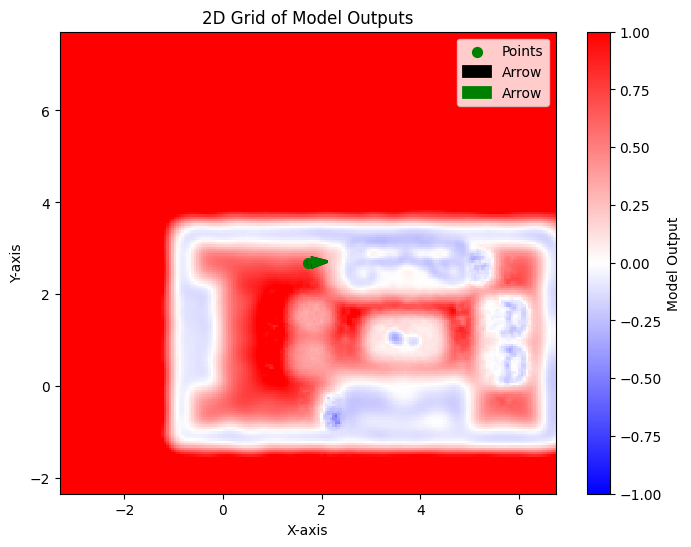

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

%matplotlib inline

def plot_2d_grid_with_model(x_range, y_range, steps, model, points=None, z_level=0, z_div=None, arrows=None):
    # Generate x and y linspace
    x_values = torch.linspace(*x_range, steps)
    y_values = torch.linspace(*y_range, steps)
    X, Y = torch.meshgrid(x_values, y_values, indexing="ij")
    
    # Flatten the grid for model input
    flattened_X = X.flatten()
    flattened_Y = Y.flatten()
    flattened_Z = torch.full_like(flattened_X, z_level)
    
    # Prepare inputs for the model
    xy_inputs = torch.stack([flattened_X, flattened_Y, flattened_Z], dim=1)
    z_inputs = torch.full((xy_inputs.shape[0], 1), z_div.item())

    output = model(xy_inputs, z_inputs)
    Z = output.view(steps, steps).detach().cpu().numpy()

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    # norm = mcolors.TwoSlopeNorm(vmin=-1e-10, vcenter=0, vmax=1e-10)
    c = ax.pcolormesh(X.numpy(), Y.numpy(), Z, shading='auto', cmap='bwr', norm=norm)
    plt.colorbar(c, ax=ax, label='Model Output')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('2D Grid of Model Outputs')

    # Plot individual points if provided
    if points:
        for point in points:
            print("Point V", point, model(torch.tensor([point]), z_div.unsqueeze(0)).cpu().tolist())
        points_x, points_y, points_z = zip(*points)  # Unpack the points into x and y coordinates
        ax.scatter(points_x, points_y, color='green', s=50, label='Points')

    # Plot the arrow if provided
    if arrows:
        for arrow in arrows:
            (x_start, y_start), (x_end, y_end), color = arrow
            ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start, 
                    head_width=0.2, head_length=0.3, fc=color, ec=color, linewidth=2, label='Arrow')

    # Add legend if points or arrow are plotted
    if points or arrows:
        ax.legend()

    plt.savefig("cylinder_safety.png")
    plt.show()

# Example usage
# model.upper_bound = 15
width = 5
t = int(slider.value)

# point.positions = [-20.5, 39.2, 3]
new_interactive_point.point = point.positions
# new_interactive_point.point[2] = -0.99
# print(new_interactive_point.point)

# new_interactive_point.point = small_pcd.mean(axis=0)
# new_interactive_point.point[2] = -0.75

print(new_interactive_point.point)

arrow_start = (new_interactive_point.point[0], new_interactive_point.point[1])
arrow_end = (new_interactive_point.point[0] + trajectory_us[t][0], new_interactive_point.point[1] + trajectory_us[t][1])
arrow_u = (arrow_start, arrow_end, 'black')

arrow_start = (new_interactive_point.point[0], new_interactive_point.point[1])
arrow_end = (new_interactive_point.point[0] + trajectory_urefs[t][0], new_interactive_point.point[1] + trajectory_urefs[t][1])
arrow_uref = (arrow_start, arrow_end, 'green')

plot_2d_grid_with_model(
    x_range=(new_interactive_point.point[0] - width, new_interactive_point.point[0] + width),
    y_range=(new_interactive_point.point[1] - width, new_interactive_point.point[1] + width),
    steps=200,
    z_div = z_div,
    model=model,
    z_level=new_interactive_point.point[2],
    points=[new_interactive_point.point],
    # points=[[1, 1.1,-1.1]],
    arrows=[arrow_u, arrow_uref]
)

[ 1.7162043  2.6881256 -0.85     ]
Point V [ 1.7162043  2.6881256 -0.85     ] [0.608356237411499]
Point V [ 1.7162043  2.6881256 -0.85     ] [0.608356237411499]


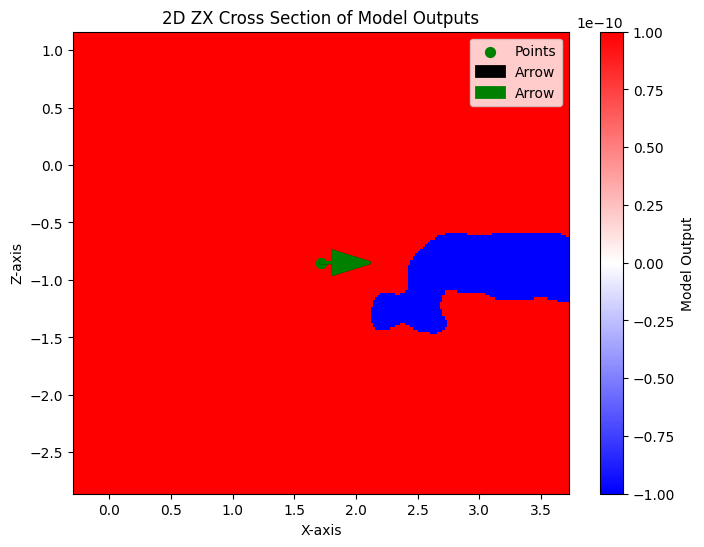

In [ ]:
import numpy as np

def plot_2d_grid_zx_section(x_range, z_range, steps, model, points=None, y_level=0, z_div=None, arrows=None):
    # Generate x and z linspace
    x_values = torch.linspace(*x_range, steps)
    z_values = torch.linspace(*z_range, steps)
    X, Z = torch.meshgrid(x_values, z_values, indexing="ij")
    
    # Flatten the grid for model input.
    # We fix y to the given y_level.
    flattened_X = X.flatten()
    flattened_Z = Z.flatten()
    flattened_Y = torch.full_like(flattened_X, y_level)
    
    # Prepare inputs for the model: note the order [x, y, z]
    inputs = torch.stack([flattened_X, flattened_Y, flattened_Z], dim=1)
    z_inputs = torch.full((inputs.shape[0], 1), z_div.item())

    output = model(inputs, z_inputs)
    output_grid = output.view(steps, steps).detach().cpu().numpy()

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    # norm = mcolors.TwoSlopeNorm(vmin=-model.upper_bound, vcenter=0, vmax=model.upper_bound)
    norm = mcolors.TwoSlopeNorm(vmin=-1e-10, vcenter=0, vmax=1e-10)
    c = ax.pcolormesh(X.numpy(), Z.numpy(), output_grid, shading='auto', cmap='bwr', norm=norm)
    plt.colorbar(c, ax=ax, label='Model Output')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Z-axis')
    ax.set_title('2D ZX Cross Section of Model Outputs')

    # Plot individual points if provided (using x and z coordinates)
    if points:
        for point in points:
            print("Point V", point, model(torch.tensor([point]), z_div.unsqueeze(0)).cpu().tolist())
        # Unpack points (assumed to be (x, y, z) tuples) and plot using x and z.
        points_x, points_y, points_z = zip(*points)
        ax.scatter(points_x, points_z, color='green', s=50, label='Points')

    # Plot arrows if provided (arrows should be given in ZX coordinates)
    if arrows:
        for arrow in arrows:
            (x_start, z_start), (x_end, z_end), color = arrow
            ax.arrow(x_start, z_start, x_end - x_start, z_end - z_start, 
                     head_width=0.2, head_length=0.3, fc=color, ec=color, linewidth=2, label='Arrow')

    if points or arrows:
        ax.legend()

    plt.savefig("cylinder_safety_zx.png")
    plt.show()

print(point.positions)

arrow_start = (point.positions[0], point.positions[2])
arrow_end = (point.positions[0] + trajectory_us[t][0], point.positions[2] + trajectory_us[t][2])
arrow_u = (arrow_start, arrow_end, 'black')

arrow_start = (point.positions[0], point.positions[2])
arrow_end = (point.positions[0] + trajectory_urefs[t][0], point.positions[2] + trajectory_urefs[t][2])
arrow_uref = (arrow_start, arrow_end, 'green')

# Example usage
# model.upper_bound = 15
width = 2
t = int(slider.value)

# positions = [-20, 40, 0.6]
positions = point.positions

plot_2d_grid_zx_section(
    x_range=(new_interactive_point.point[0] - width, new_interactive_point.point[0] + width),
    z_range=(new_interactive_point.point[2] - width, new_interactive_point.point[2] + width),
    steps=200,
    z_div = z_div,
    model=model,
    y_level=new_interactive_point.point[1],
    points=[new_interactive_point.point, positions],
    arrows=[arrow_u, arrow_uref]
)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import torch

# %matplotlib inline

# def plot_2d_grid_with_model(x_range, y_range, steps, model, points=None, z_level=0, z_div=None, arrows=None):
#     # Generate x and y linspace
#     x_values = torch.linspace(*x_range, steps)
#     y_values = torch.linspace(*y_range, steps)
#     X, Y = torch.meshgrid(x_values, y_values, indexing="ij")
    
#     # Flatten the grid for model input
#     flattened_X = X.flatten()
#     flattened_Y = Y.flatten()
#     flattened_Z = torch.full_like(flattened_X, z_level)
    
#     # Prepare inputs for the model
#     xy_inputs = torch.stack([flattened_X, flattened_Y, flattened_Z], dim=1)
#     z_inputs = torch.full((xy_inputs.shape[0], 1), z_div.item())

#     output = model(xy_inputs, z_inputs)
#     # output = torch.clamp(output, max=model.upper_bound, min=-model.upper_bound)
#     Z = output.view(steps, steps).detach().numpy()

#     # Plotting
#     fig, ax = plt.subplots(figsize=(8, 6))
#     norm = mcolors.TwoSlopeNorm(vmin=min(-model.upper_bound, -0.5), vcenter=0, vmax=1)
#     c = ax.pcolormesh(X.numpy(), Y.numpy(), Z, shading='auto', cmap='bwr', norm=norm)
#     plt.colorbar(c, ax=ax, label='Model Output')
#     ax.set_xlabel('X-axis')
#     ax.set_ylabel('Y-axis')
#     ax.set_title('2D Grid of Model Outputs')

#     # Plot individual points if provided
#     if points:
#         for point in points:
#             print("Point V", point, model(torch.tensor([point]), z_div.unsqueeze(0), calc_jacobian=False).cpu().tolist())
#         points_x, points_y, points_z = zip(*points)  # Unpack the points into x and y coordinates
#         ax.scatter(points_x, points_y, color='green', s=50, label='Points')

#     # Plot the arrow if provided
#     if arrows:
#         for arrow in arrows:
#             (x_start, y_start), (x_end, y_end), color = arrow
#             ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start, 
#                     head_width=0.2, head_length=0.3, fc=color, ec=color, linewidth=2, label='Arrow')

#     # Add legend if points or arrow are plotted
#     if points or arrows:
#         ax.legend()

#     plt.savefig("cylinder_safety.png")
#     plt.show()

# # Example usage
# # model.upper_bound = 15
# width = 4
# center = [-18, 39]
# plot_2d_grid_with_model(
#     x_range=(center[0] - width, center[0] + width),
#     y_range=(center[1] - width, center[1] + width),
#     steps=200,
#     z_div = z_div,
#     model=model,
#     z_level=0.6,
#     points = [[-15.867135,38.902016,0.5692017]]
# )